# Estimating COVID-19's $R_t$ in Real-Time
Nidhi Gupta - April 17

Thanks to Kevin Systrom!

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, we don't yet use $R_t$ in this way. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) granularity of $R_t$.

What follows is a solution to this problem at the Indian State level. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a Bayesian approach. While this paper estimates a static $R$ value, here we introduce a process model with Gaussian noise to estimate a time-varying $R_t$.

If it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so you can calibrate your beliefs as you wish. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in India.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

FILTERED_REGION_CODES = ['AS1', 'GU1', 'PR1', 'VI1', 'MP1']

%config InlineBackend.figure_format = 'retina'

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __likelihood__ of seeing $k$ new cases given $R_t$ times ...
- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- divided by the probability of seeing this many cases in general.

This is for a single day. To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. We will assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter (see below on how we estimate $\sigma$). So on day one:

$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$

On day two:

$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$

etc.

### Choosing a Likelihood Function $P\left(k_t|R_t\right)$

A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


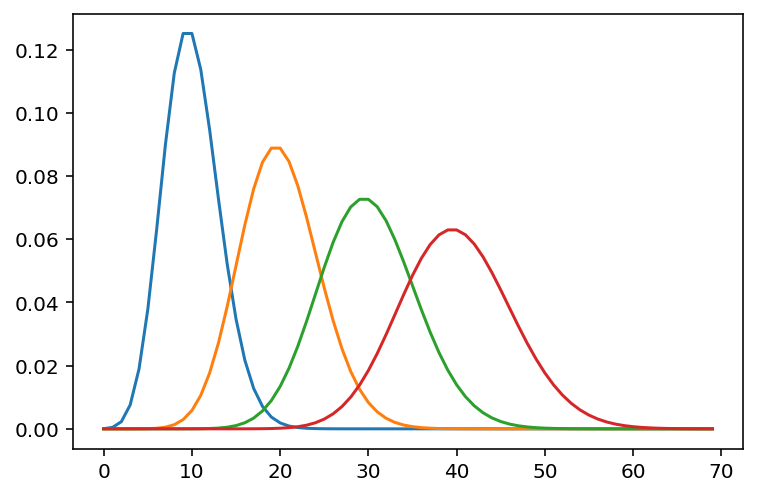

In [3]:
plt.plot(y)
plt.show()

> __Note__: this was a terse expression which makes it tricky. All I did was to make $k$ a column. By giving it a column for $k$ and a 'row' for lambda it will evaluate the pmf over both and produce an array that has $k$ rows and lambda columns. This is an efficient way of producing many distributions all at once, and __you will see it used again below__!

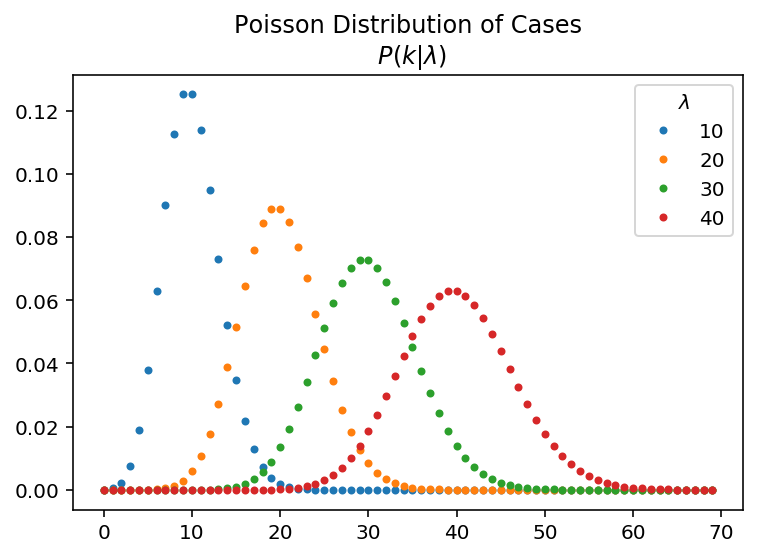

In [4]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $P(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__

For example, imagine we observe $k=20$ new cases, and we want to know how likely each $\lambda$ is:

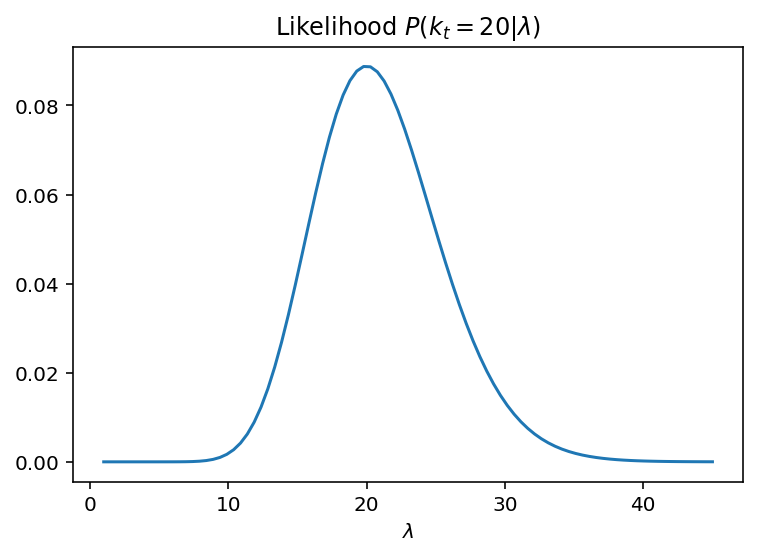

In [5]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$');

This says that if we see 20 cases, the most likely value of $\lambda$ is (not surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was 40 and we saw 20.

Great. We have $P\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$ but we were looking for $P\left(k_t|R_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $\lambda$ and $R_t$

### Connecting $\lambda$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval ([about 7 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### Evaluating the Likelihood Function

To continue our example, let's imagine a sample of new case counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

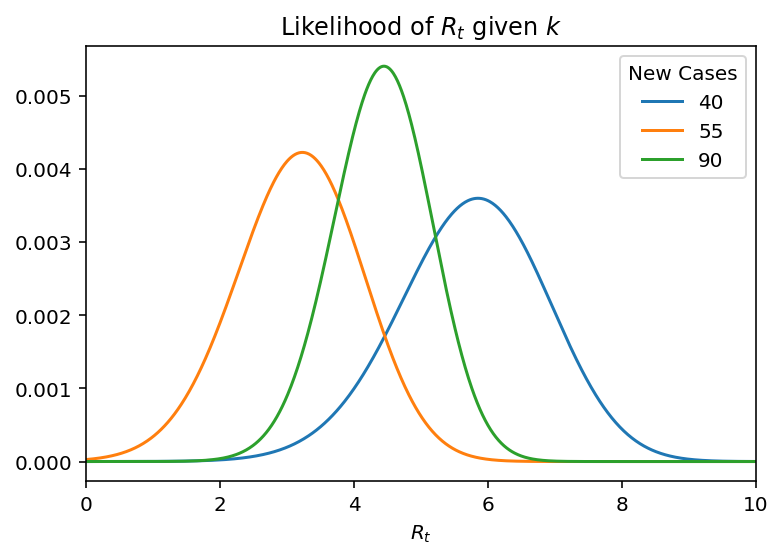

In [6]:
# Assume k new cases, where k can be any number from below array, let's look at what values of Rt we get
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt. We have taken Rt max to be 12. Rt should not go as high as 12
# And created a range of Rt values between 0 to 12
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# 7 is number of days in which the cases double 
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# So the lambda equation was only to obtain the relation between Rt and lambda
# So that we get values for lambda for the poisson distribution. 
# Note that we have N-1 lambdas because on the first day of an outbreak you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood without our Gaussian update) to get the posteriors. Let's do that using the cumulative product of each successive day:

In [7]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)
posteriors
columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
columns
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

posteriors

Day               1             2             3
0.00   7.502900e-08  3.631459e-09  1.832299e-15
0.01   7.749643e-08  3.861253e-09  2.069567e-15
0.02   8.004218e-08  4.105152e-09  2.337084e-15
0.03   8.266861e-08  4.363993e-09  2.638642e-15
0.04   8.537820e-08  4.638660e-09  2.978503e-15
...             ...           ...           ...
11.96  3.268065e-12  8.446701e-41  6.259773e-74
11.97  3.017708e-12  6.417063e-41  3.712038e-74
11.98  2.785986e-12  4.872262e-41  2.198760e-74
11.99  2.571552e-12  3.697173e-41  1.300930e-74
12.00  2.373158e-12  2.803840e-41  7.688473e-75

[1201 rows x 3 columns]

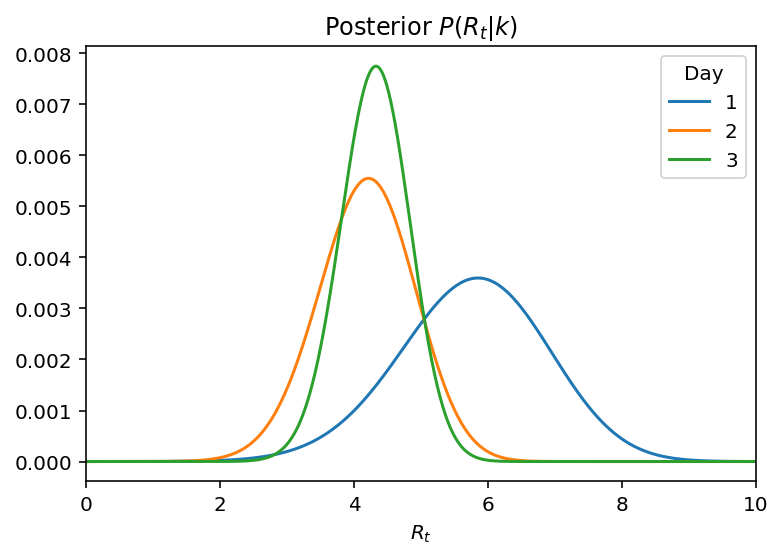

In [8]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [9]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

In [10]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

Low_90  High_90
Day                 
1      3.99     7.65
2      3.03     5.40
3      3.49     5.19

Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

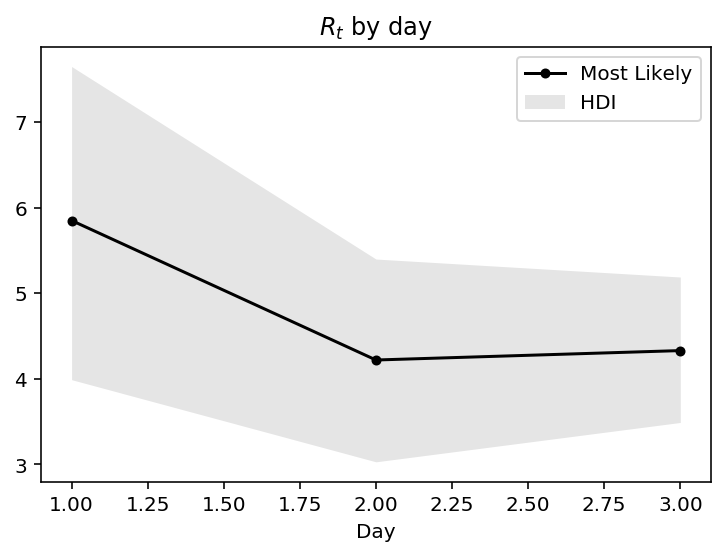

In [11]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

We can see that the most likely value of $R_t$ changes with time and the highest-density interval narrows as we become more sure of the true value of $R_t$ over time. Note that since we only had four days of history, I did not apply the process to this sample. Next, however, we'll turn to a real-world application where this process is necessary.

# Real-World Application to Indian Data

### Setup

Load Indian state case data from covid19india.org

In [12]:
url = 'http://api.covid19india.org/states_daily_csv/confirmed.csv'
states0 = pd.read_csv(url, parse_dates=['date'])
states0.tail()

date     TT  AN   AP  AR   AS   BR  CH   CT  DD  ...   RJ  SK   TG  \
98  2020-06-20  15918   0  491   0  249  213  23  116   0  ...  381   0  546   
99  2020-06-21  15151   1  477   4  332  162   2  121   0  ...  393   8  730   
100 2020-06-22  13560   0  443   9  267  228   5   47   0  ...  302   0  872   
101 2020-06-23  15656   2  462  10  203  157   7   83   0  ...  395   1  879   
102 2020-06-24  16868   6  497   2  226  223   2   34   0  ...  382   4  891   

       TN  TR    UN   UP   UT   WB  Unnamed: 40  
98   2396   8   338  541  124  441          NaN  
99   2532  35  -138  596   43  414          NaN  
100  2710  16 -1295  591   58  413          NaN  
101  2516  23   183  571  133  370          NaN  
102  2865   0   126  664   88  445          NaN  

[5 rows x 41 columns]

In [13]:
states0 = states0.drop(['Unnamed: 40'], axis=1)

states0.rename(columns = {'TT':'India', 'AN':'Andaman and Nicobar Islands'
                                   , 'AP':'Andhra Pradesh', 'AR':'Arunachal Pradesh', 'AS':'Assam', 'BR':'Bihar'
                                   , 'CH':'Chandigarh', 'CT':'Chhattisgarh', 'DN':'Dadra and Nagar Haveli'
                                   , 'DD':'Daman and Diu', 'DL':'Delhi', 'GA':'Goa', 'GJ':'Gujarat'
                                   , 'HR':'Haryana', 'HP':'Himachal Pradesh', 'JK':'Jammu and Kashmir'
                                   , 'JH':'Jharkhand', 'KA':'Karnataka', 'KL':'Kerala'
                                   , 'LA':'Ladakh', 'LD':'Lakshadweep', 'MP':'Madhya Pradesh', 'MH':'Maharashtra'
                                   , 'MN':'Manipur', 'ML':'Meghalaya', 'MZ':'Mizoram'
                                   , 'NL':'Nagaland', 'OR':'Odisha', 'PY':'Puducherry', 'PB':'Punjab'
                                   , 'RJ':'Rajasthan', 'SK':'Sikkim', 'TN':'Tamil Nadu', 'TG':'Telangana'
                                   , 'TR':'Tripura', 'UP':'Uttar Pradesh'
                                   , 'UT':'Uttarakhand', 'WB':'West Bengal'}, inplace = True)

# wide to long format
states1 = states0.melt(id_vars='date', var_name='state')
states1 = states1.rename(columns={'date': 'date', 'state': 'state' , 'value' : 'positive'})
states1 = states1[['state', 'date', 'positive']]
states1['positive'] = states1['positive'].fillna(0)
states1.positive = states1.positive.astype(int)
print(states1.isnull().sum())
states1.tail()

state       0
date        0
positive    0
dtype: int64


state       date  positive
4012  West Bengal 2020-06-20       441
4013  West Bengal 2020-06-21       414
4014  West Bengal 2020-06-22       413
4015  West Bengal 2020-06-23       370
4016  West Bengal 2020-06-24       445

In [14]:
states1[states1.positive<0]

state       date  positive
2361  Meghalaya 2020-06-17        -1
2946     Punjab 2020-05-15        -3
3566    Tripura 2020-05-17        -2
3691         UN 2020-06-08      -773
3694         UN 2020-06-11      -296
3695         UN 2020-06-12      -616
3696         UN 2020-06-13      -331
3697         UN 2020-06-14      -548
3698         UN 2020-06-15      -464
3704         UN 2020-06-21      -138
3705         UN 2020-06-22     -1295

In [15]:
states1.loc[(states1['state'] == 'Punjab') & (states1['date']== '2020-05-15'), 'positive'] = 0
states1.loc[(states1['state'] == 'Tripura') & (states1['date']== '2020-05-17'), 'positive'] = 0
states1[states1.positive<0]

state       date  positive
2361  Meghalaya 2020-06-17        -1
3691         UN 2020-06-08      -773
3694         UN 2020-06-11      -296
3695         UN 2020-06-12      -616
3696         UN 2020-06-13      -331
3697         UN 2020-06-14      -548
3698         UN 2020-06-15      -464
3704         UN 2020-06-21      -138
3705         UN 2020-06-22     -1295

In [16]:
states1.to_csv('states2.csv')

In [17]:
states = pd.read_csv('states2.csv',
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()
states.tail()

state        date      
West Bengal  2020-06-20    441
             2020-06-21    414
             2020-06-22    413
             2020-06-23    370
             2020-06-24    445
Name: positive, dtype: int64

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m

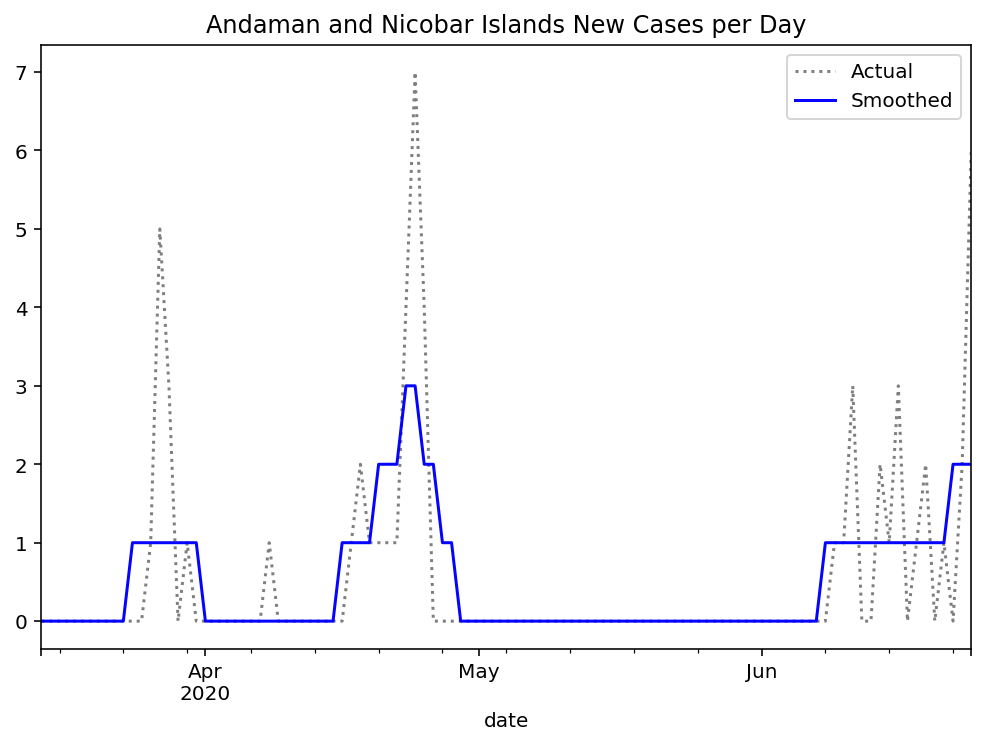

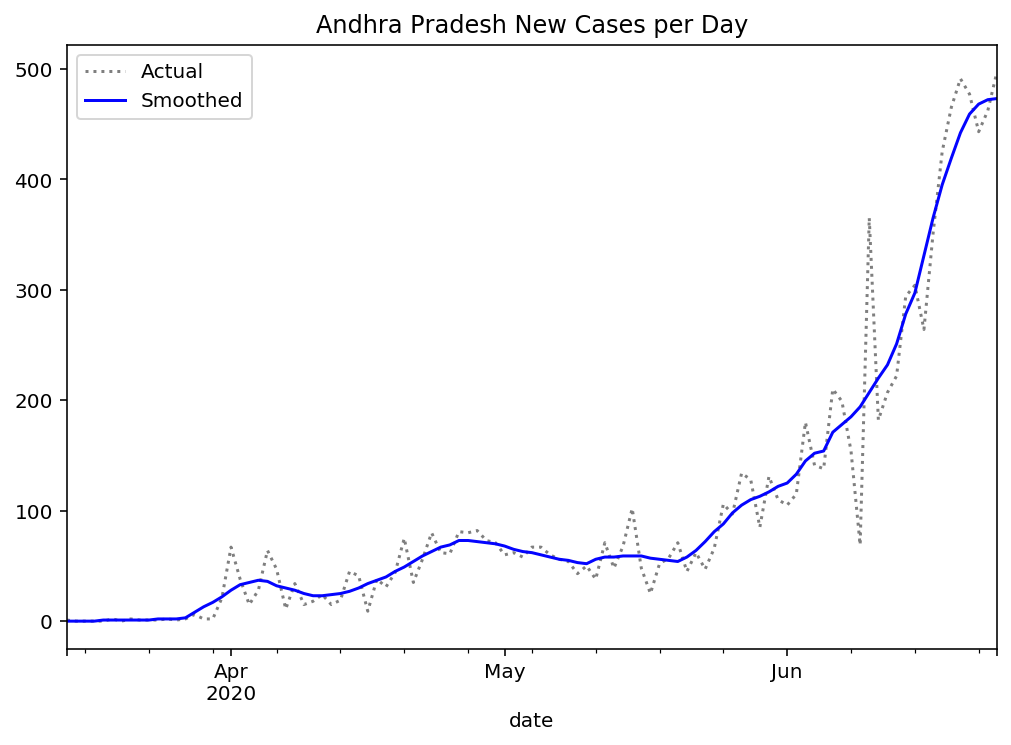

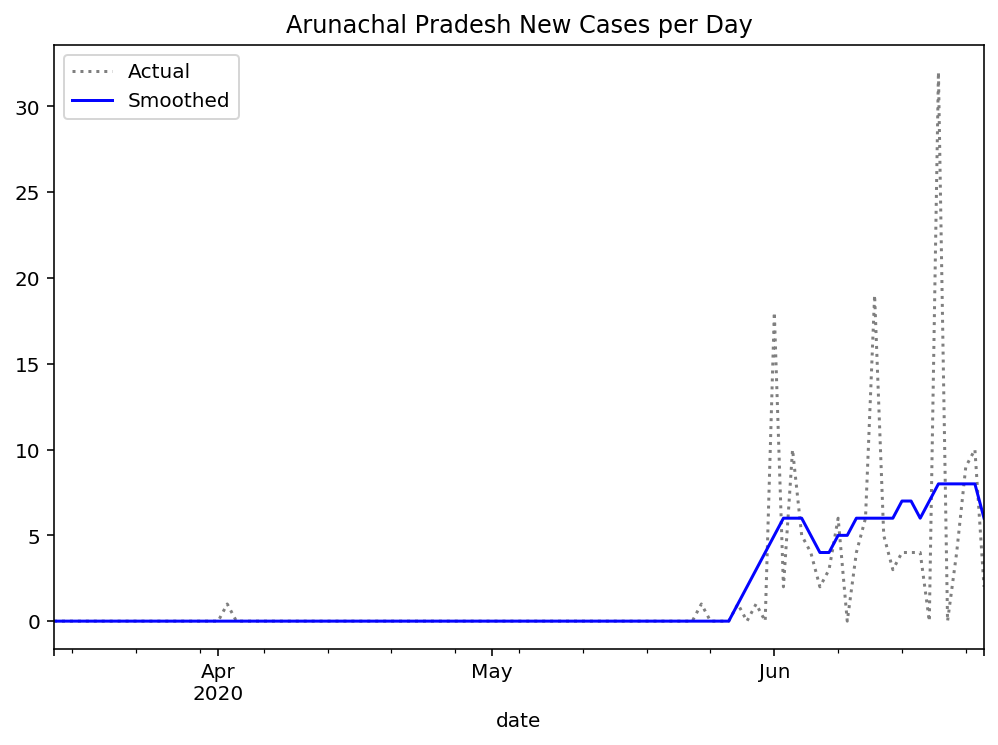

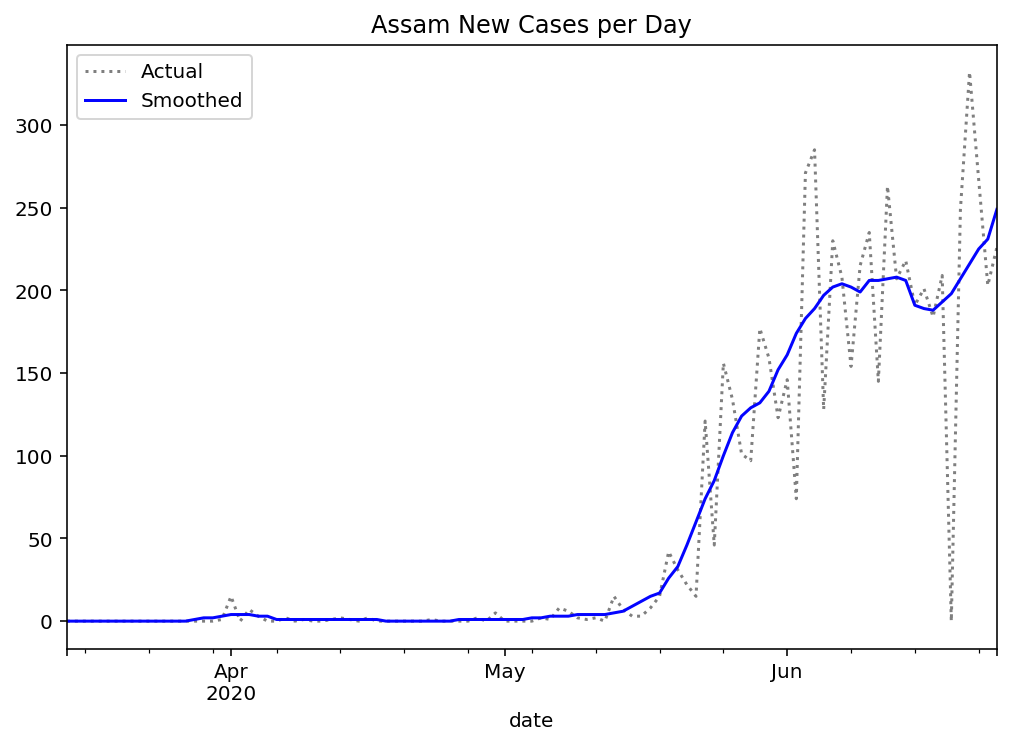

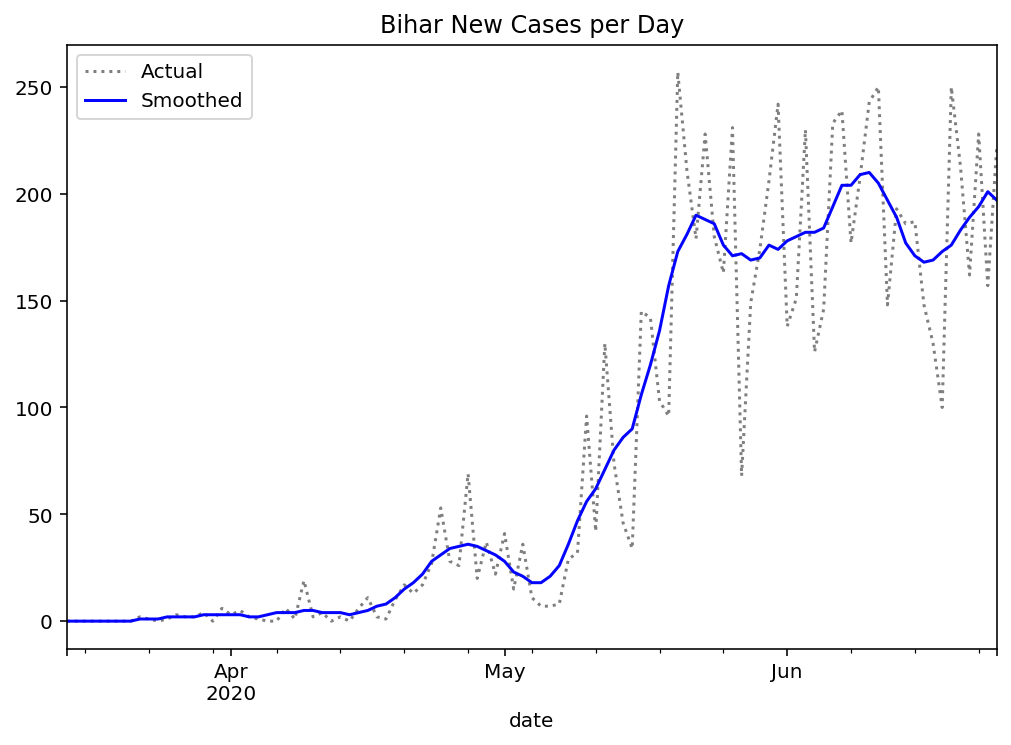

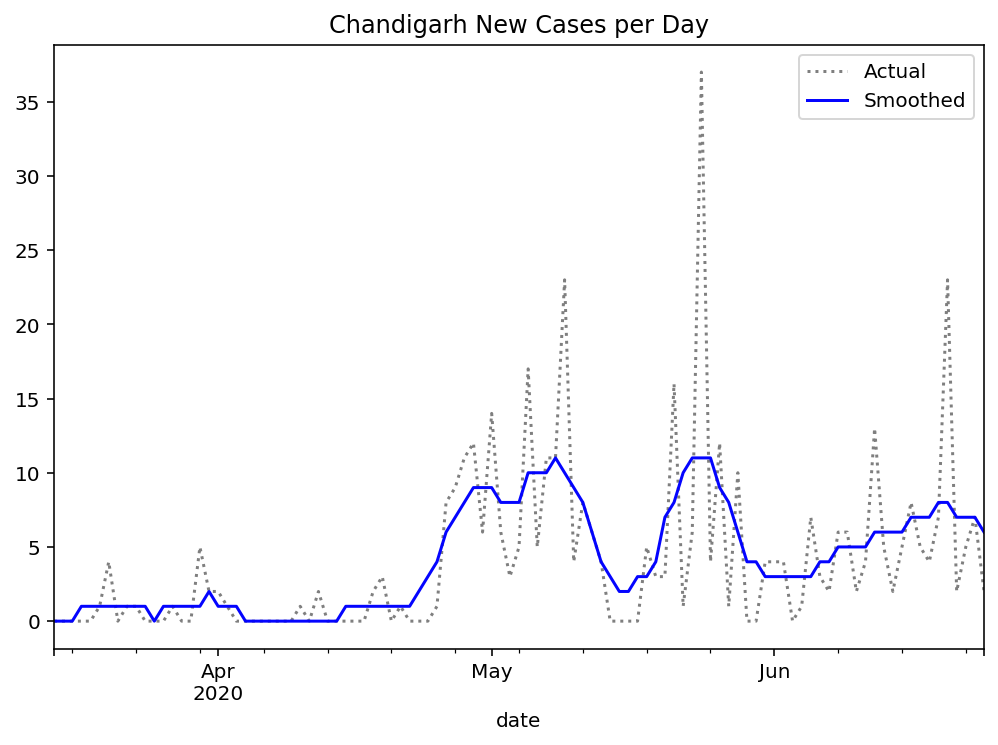

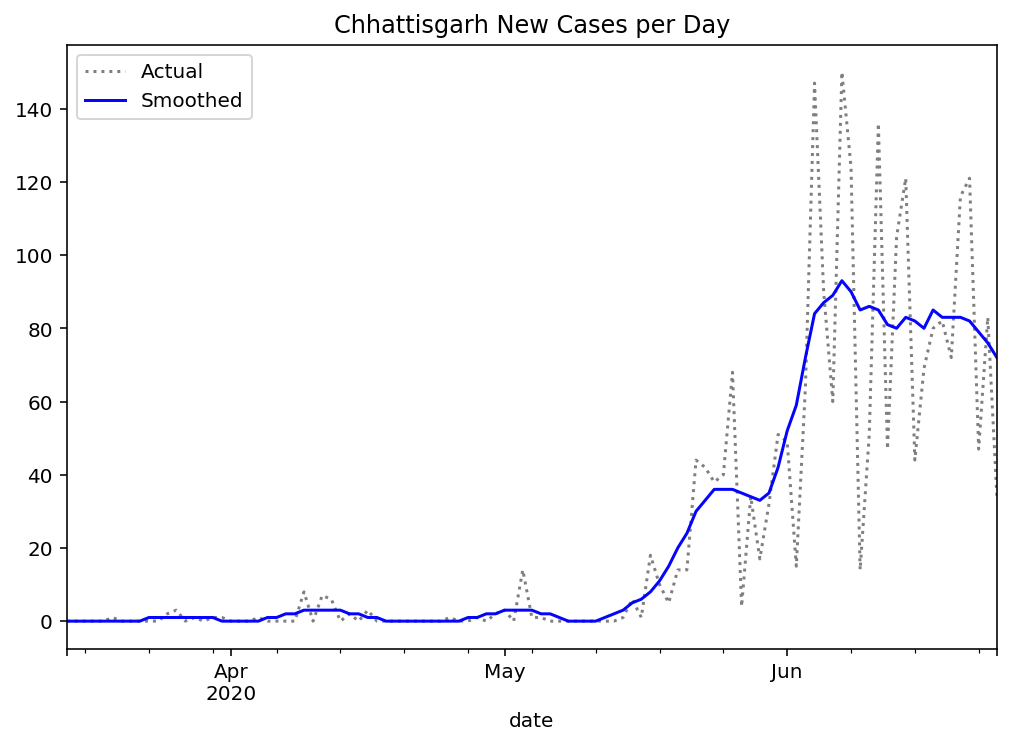

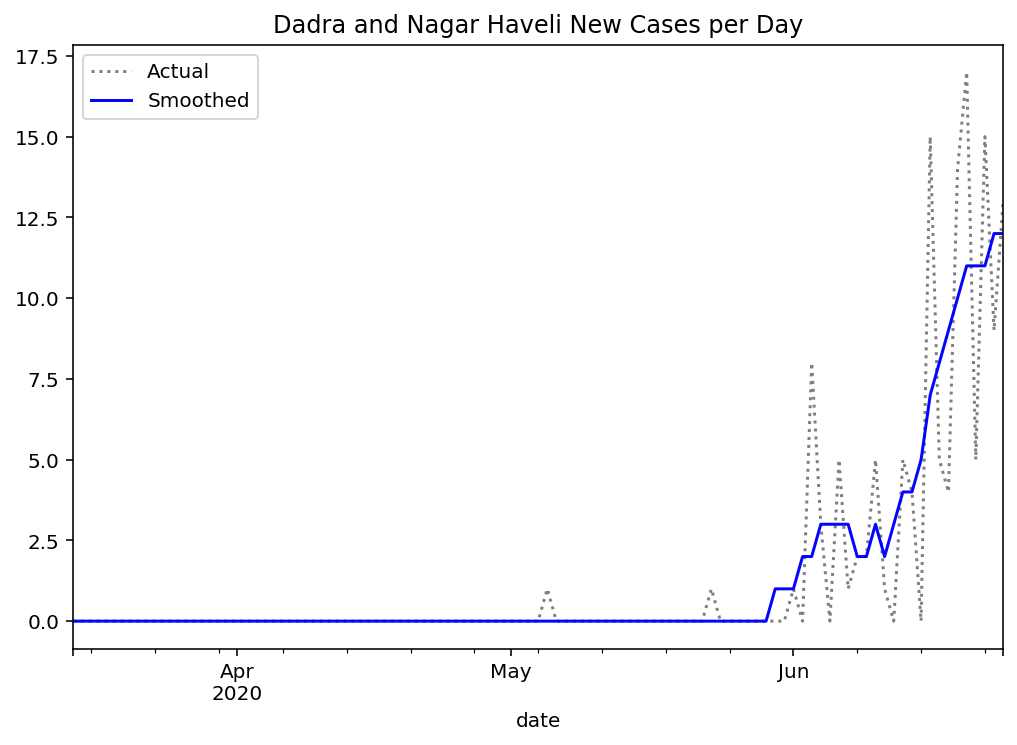

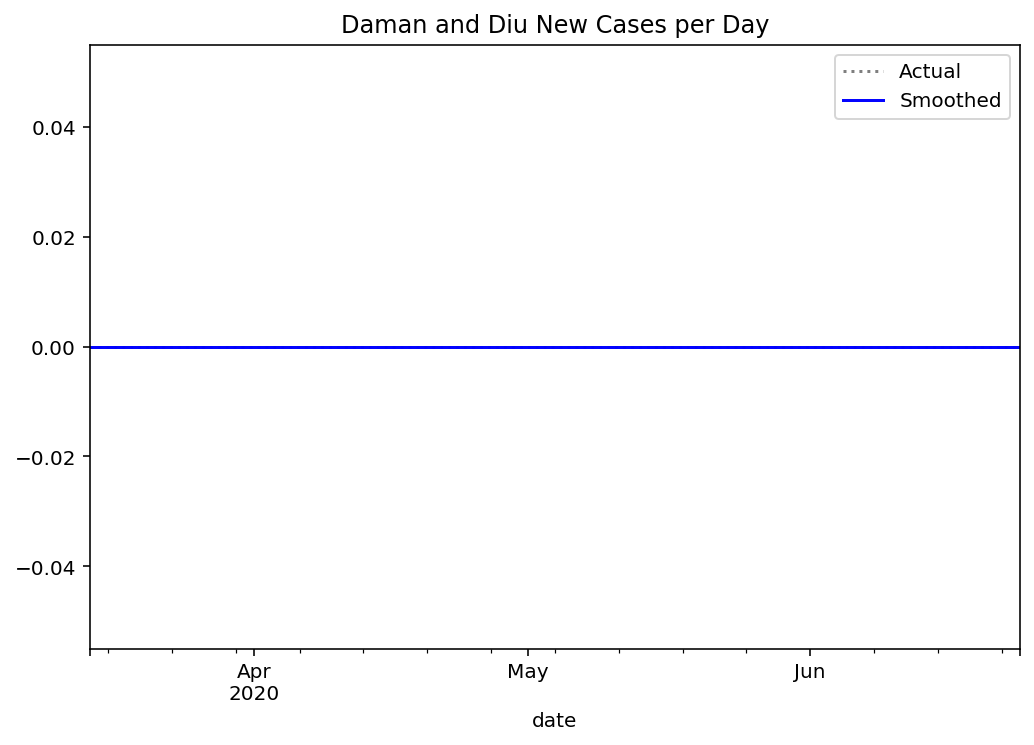

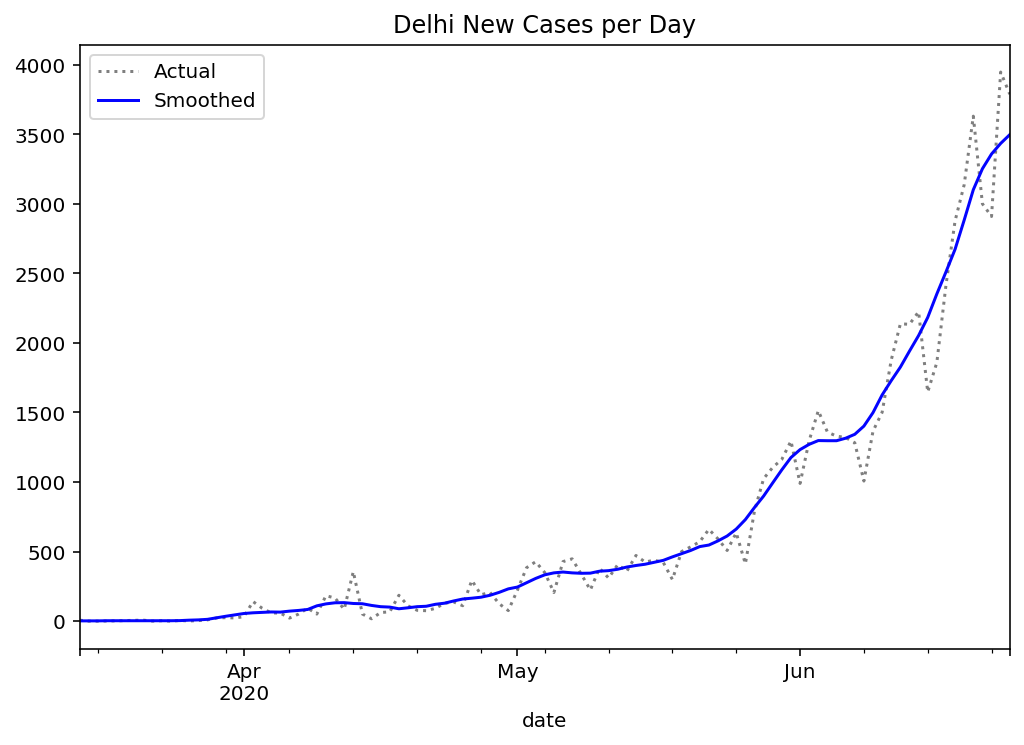

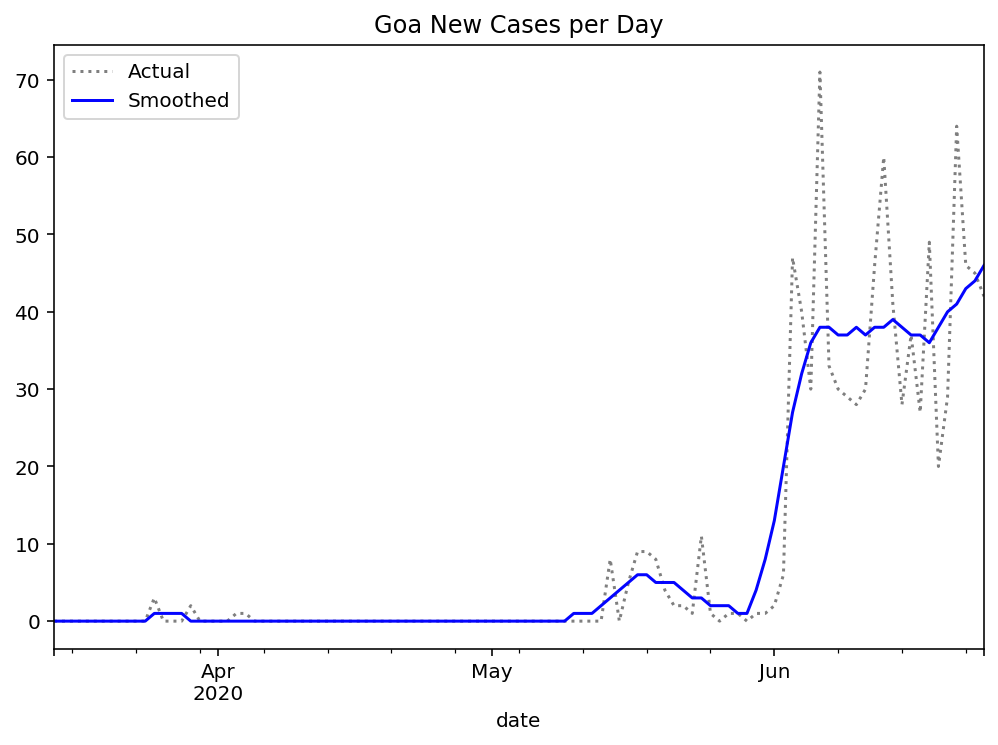

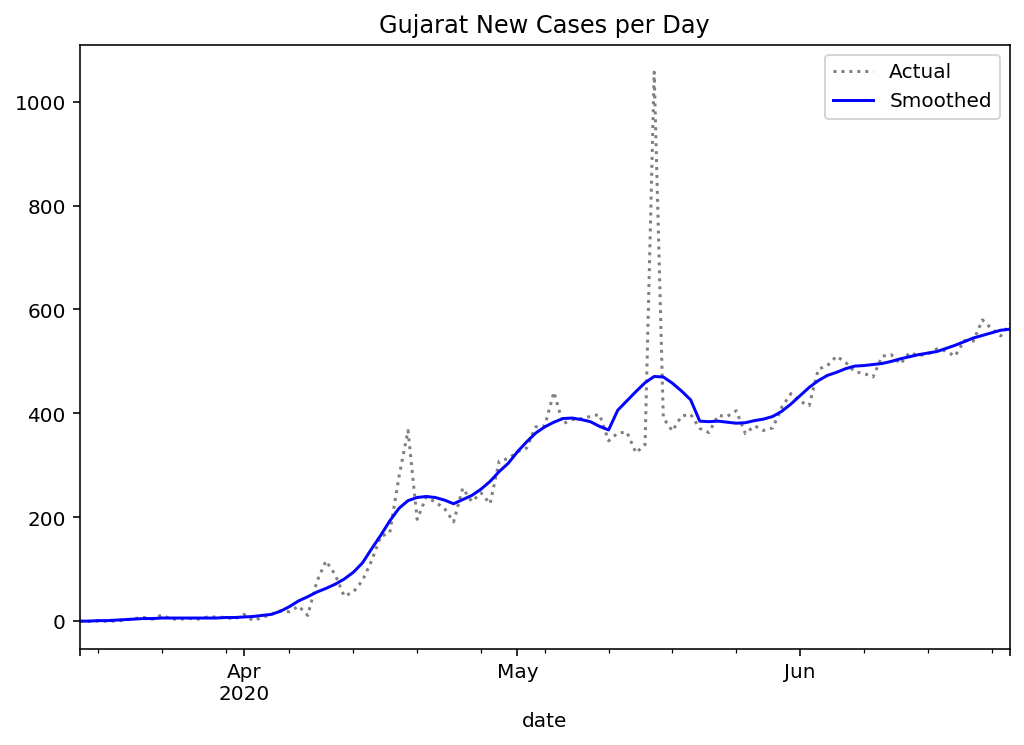

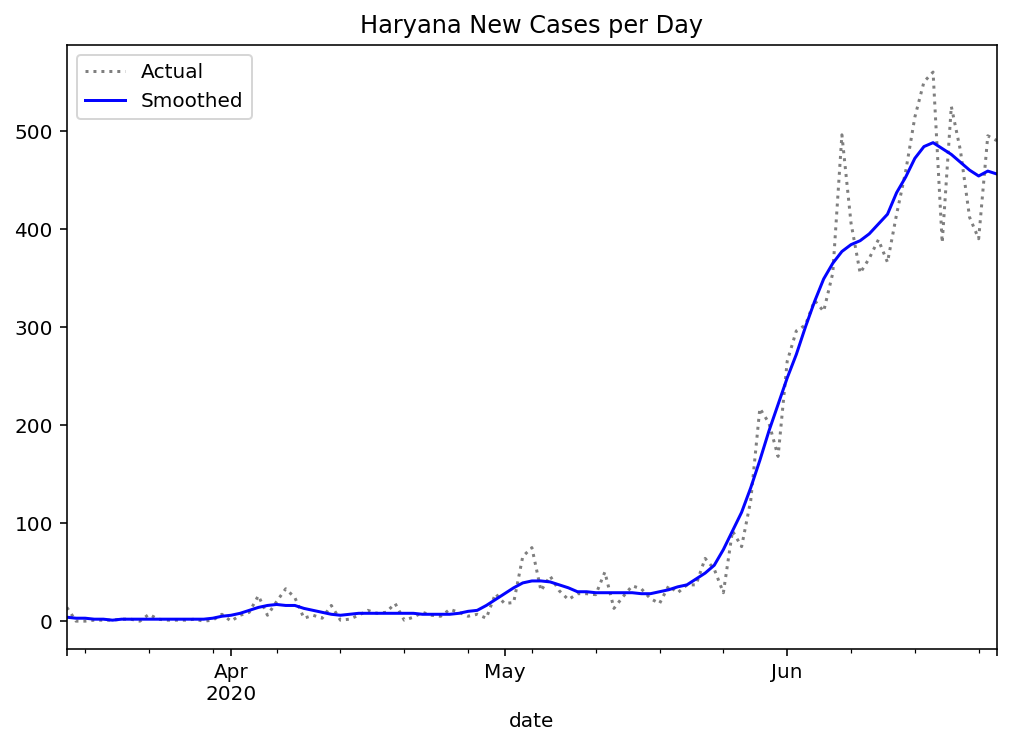

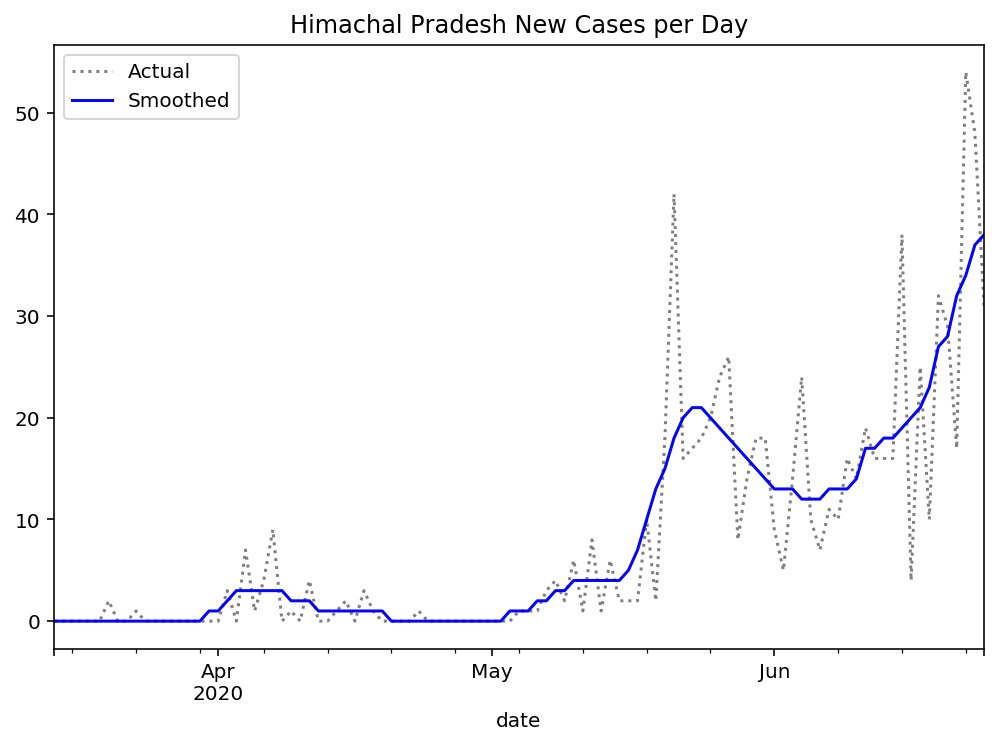

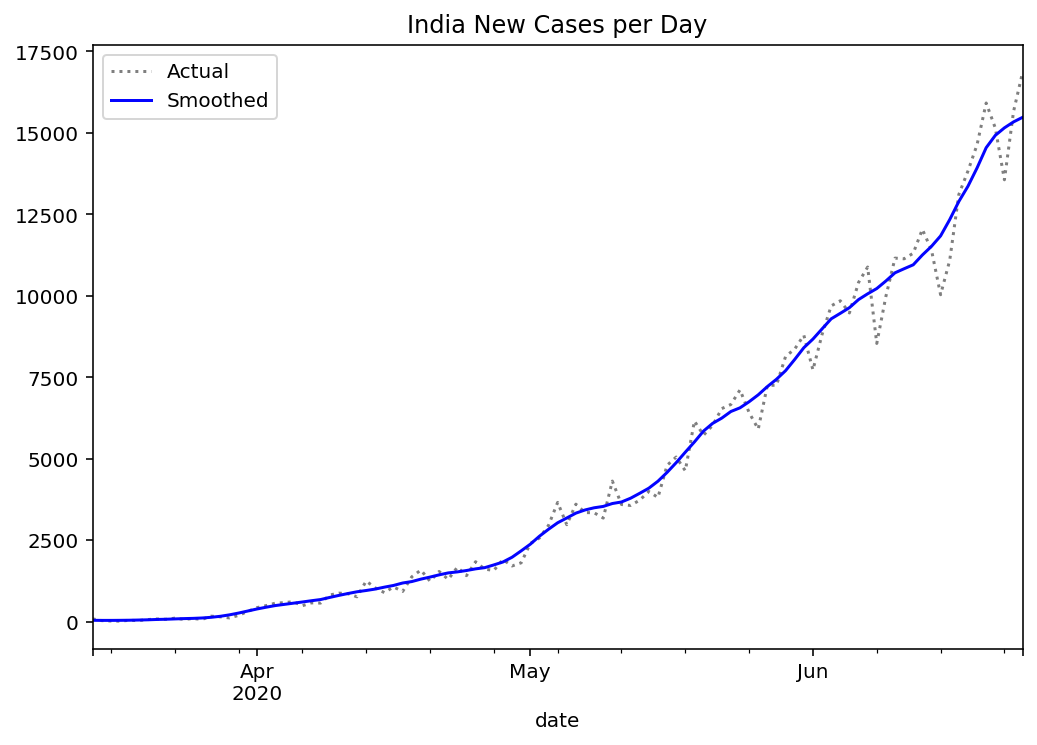

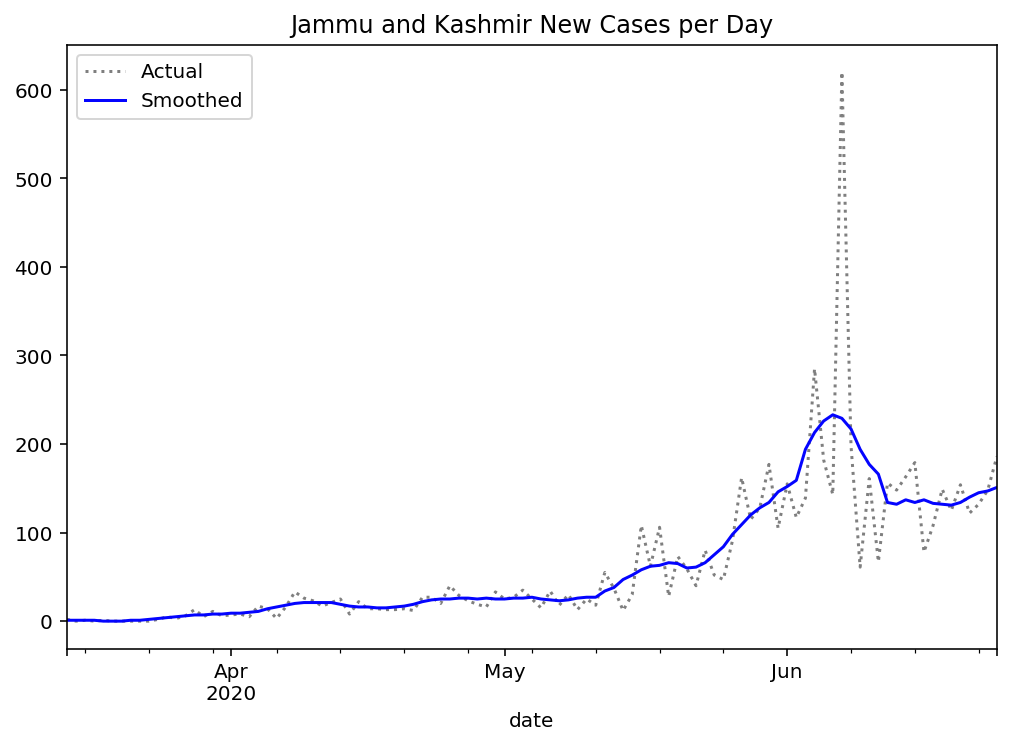

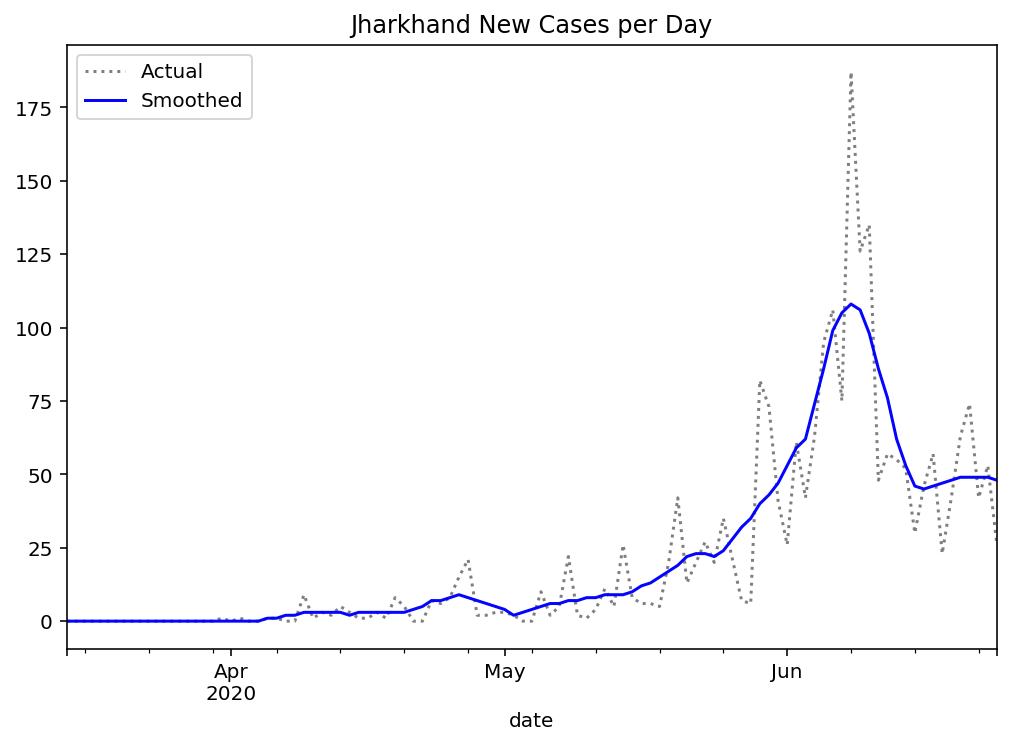

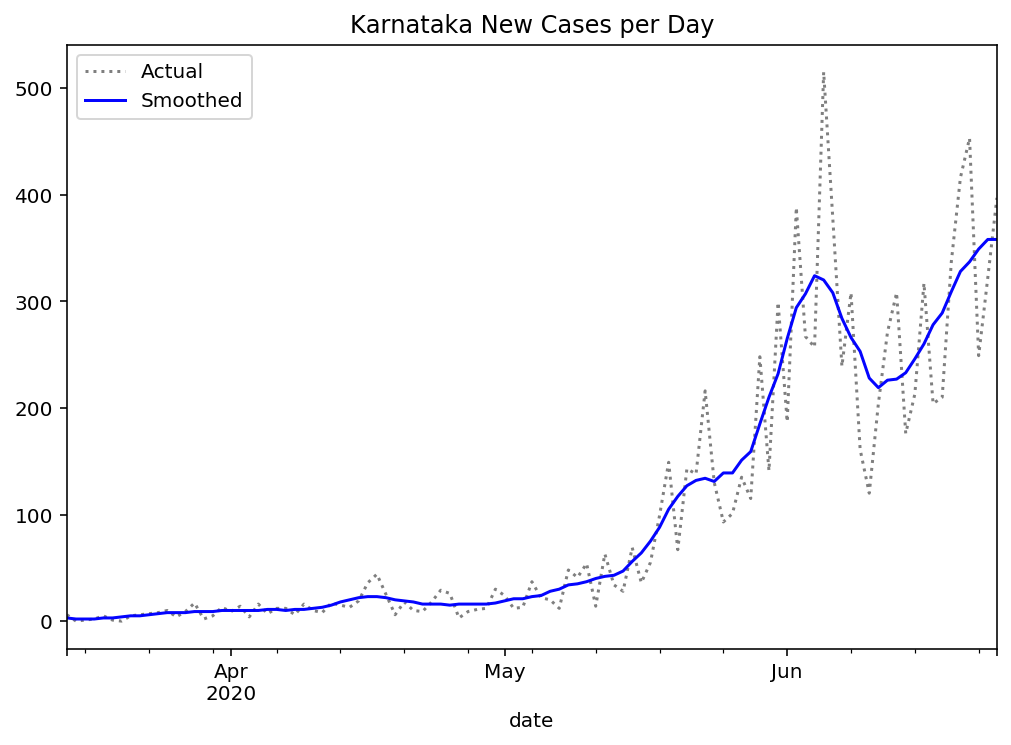

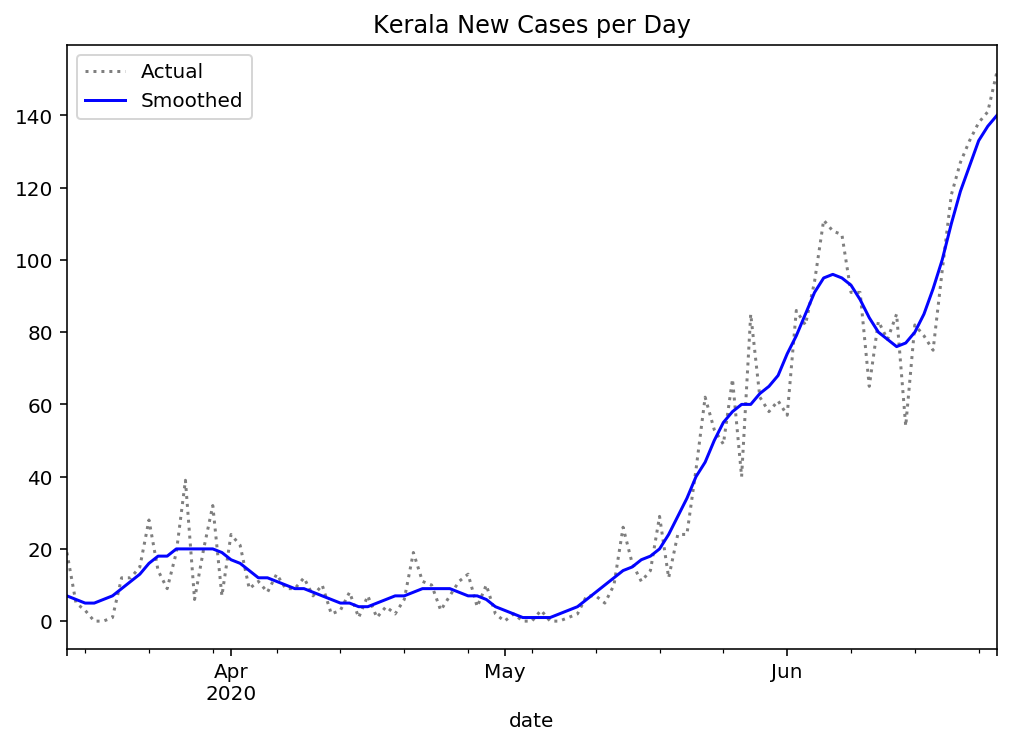

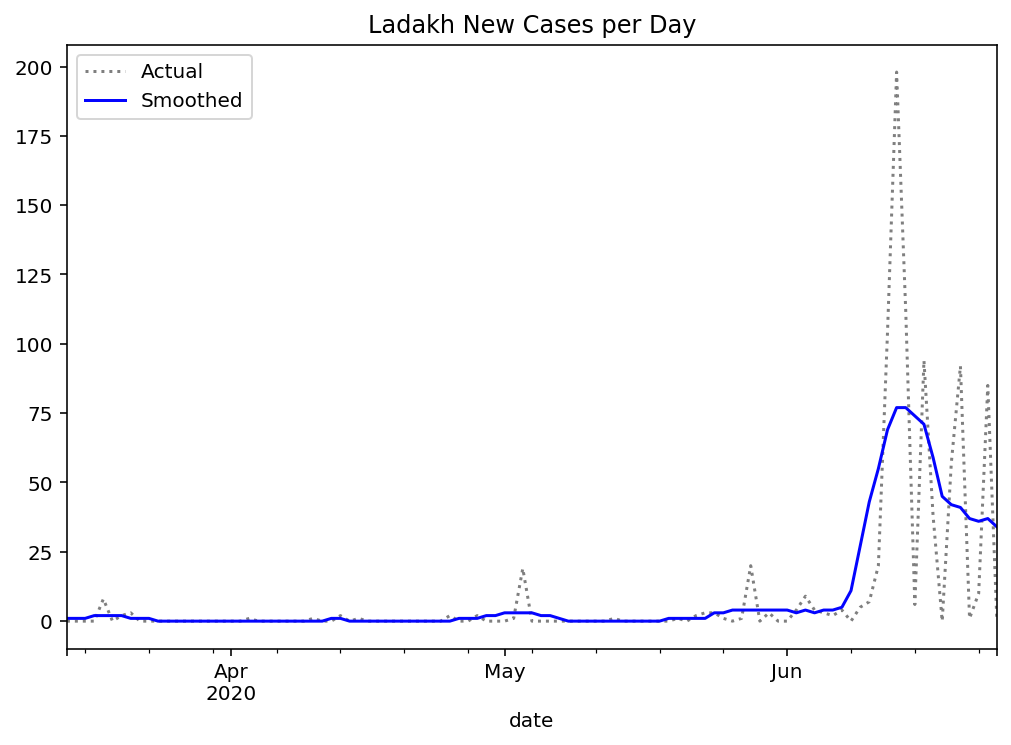

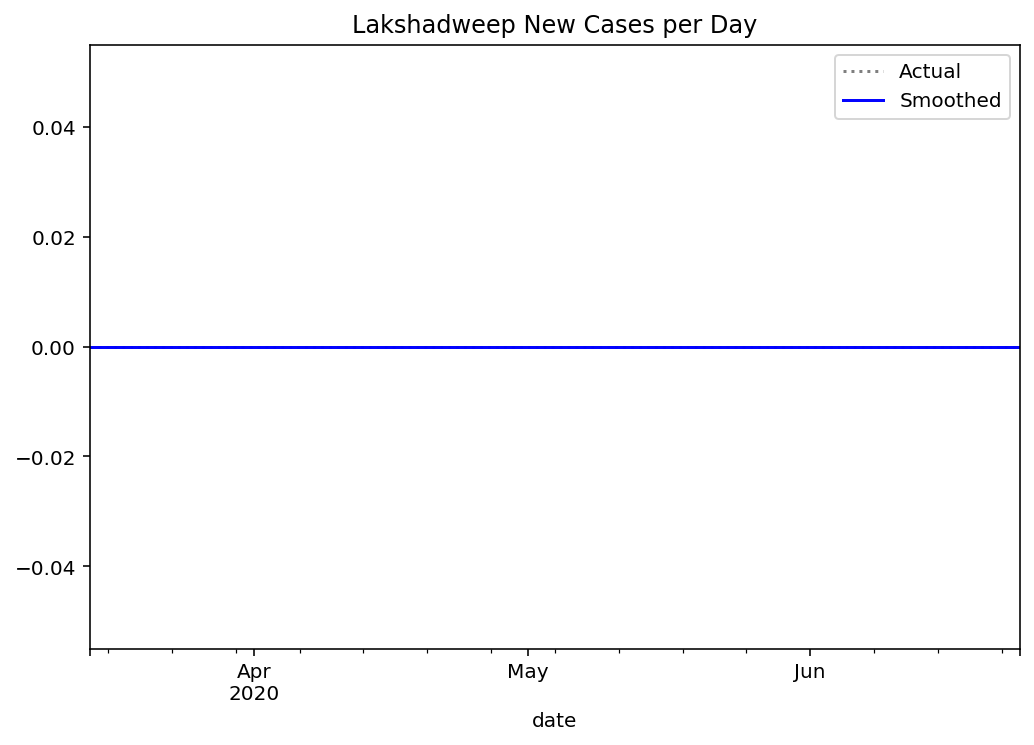

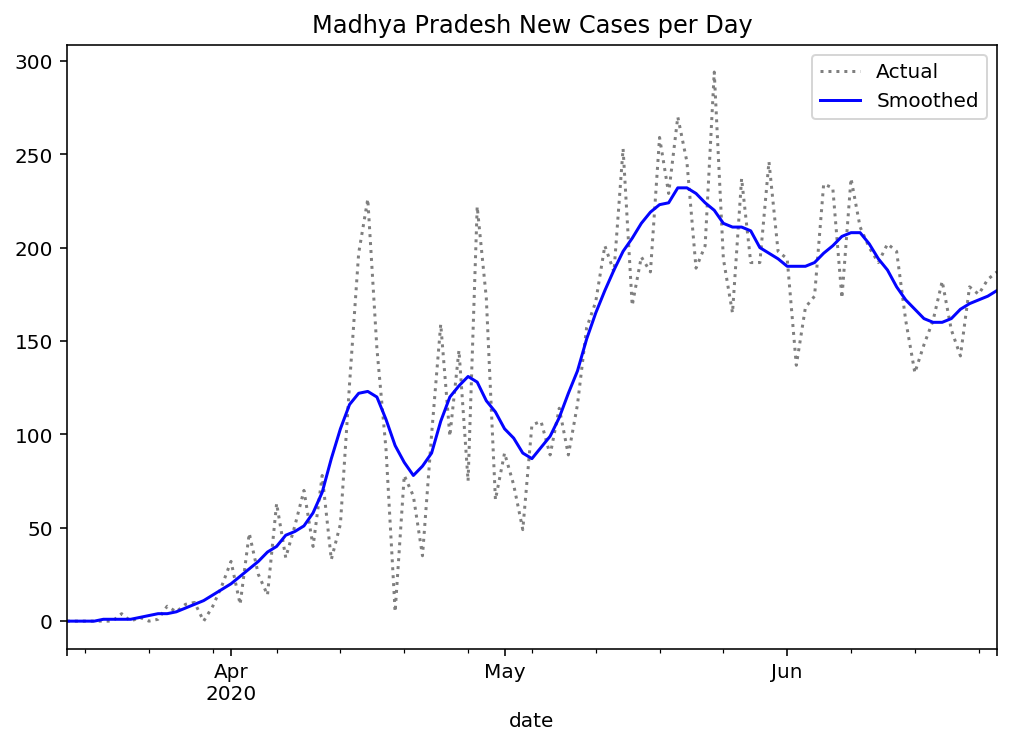

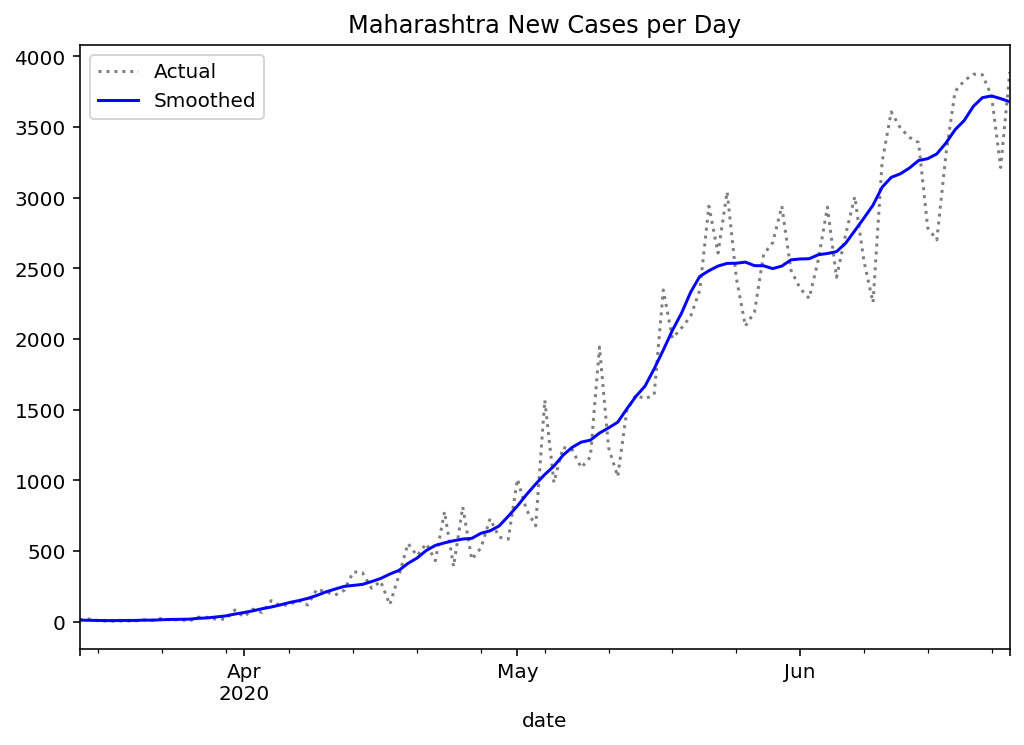

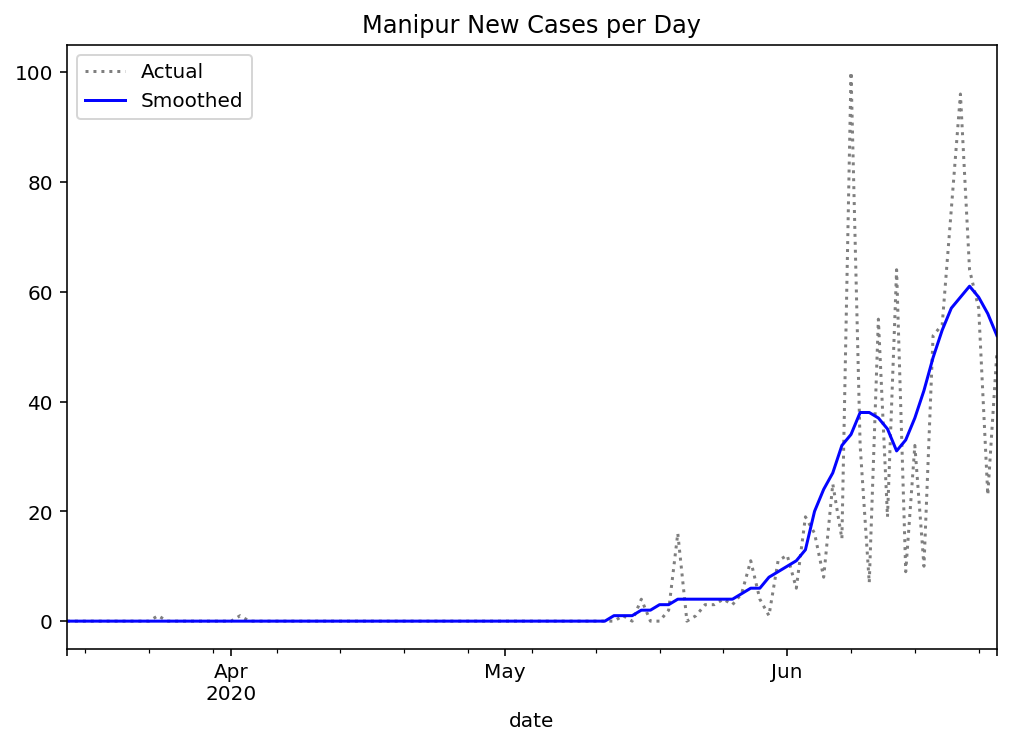

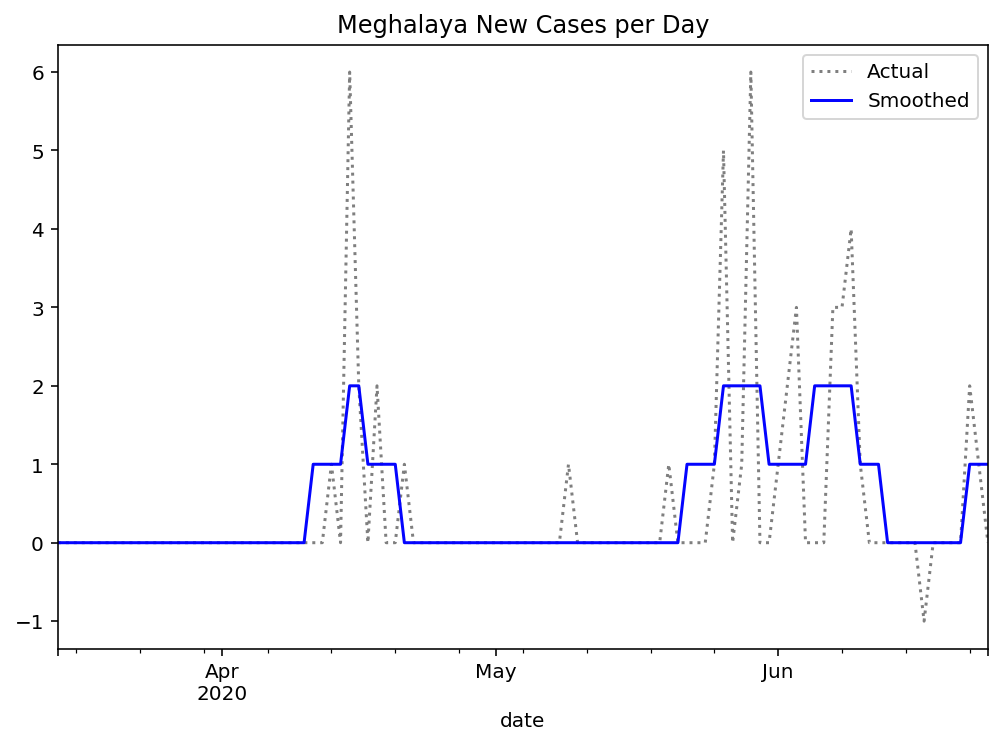

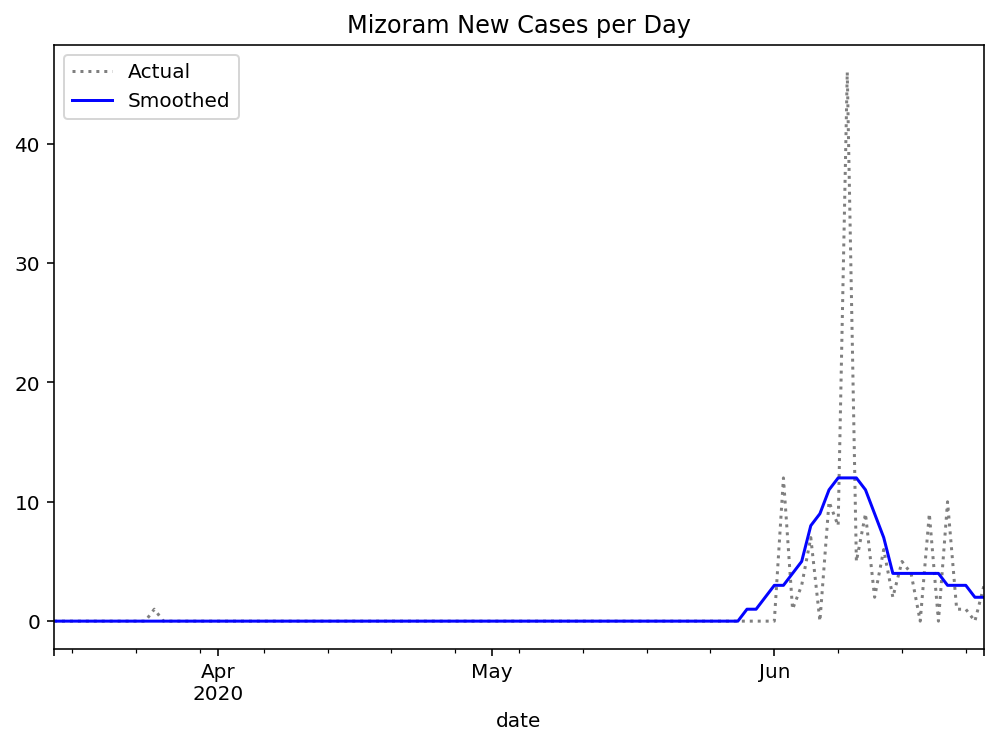

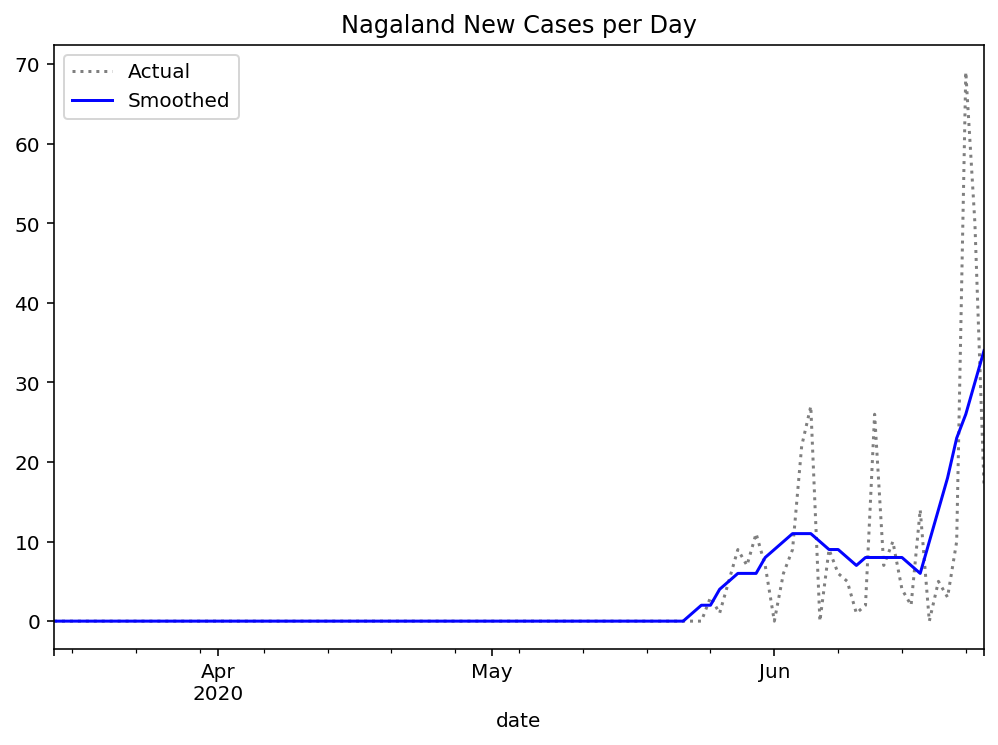

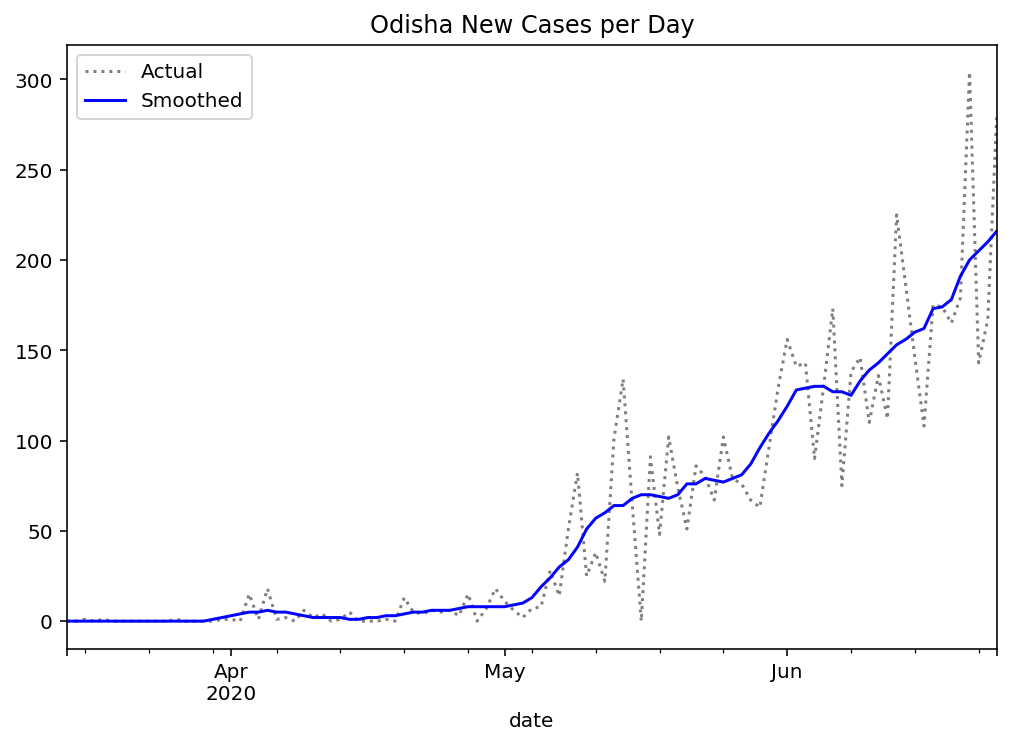

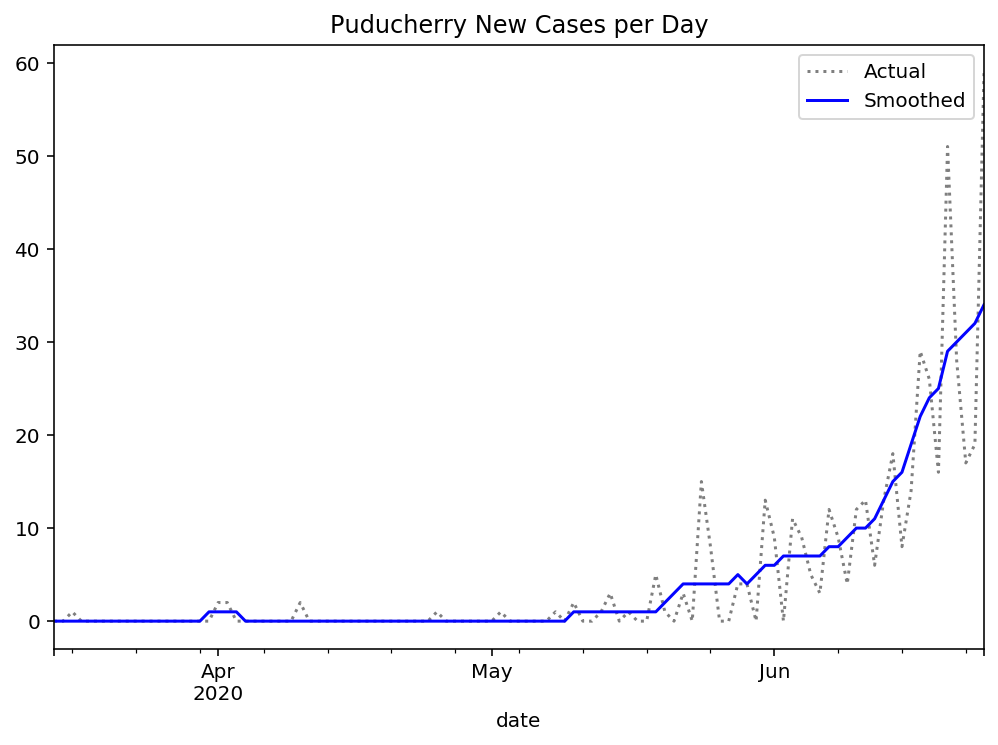

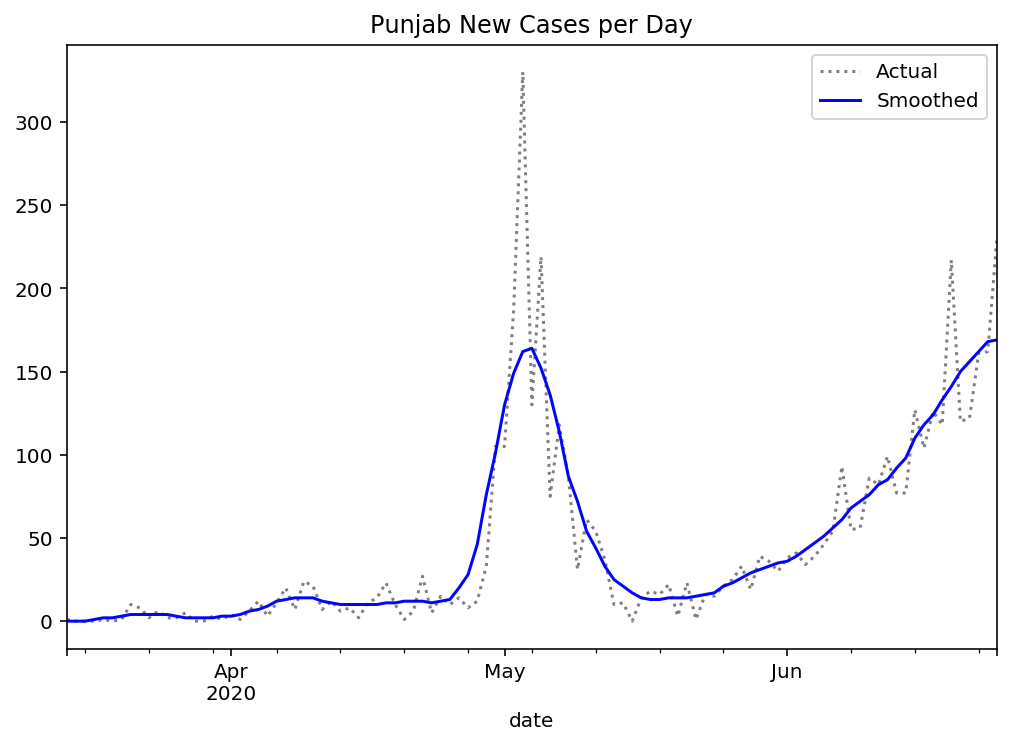

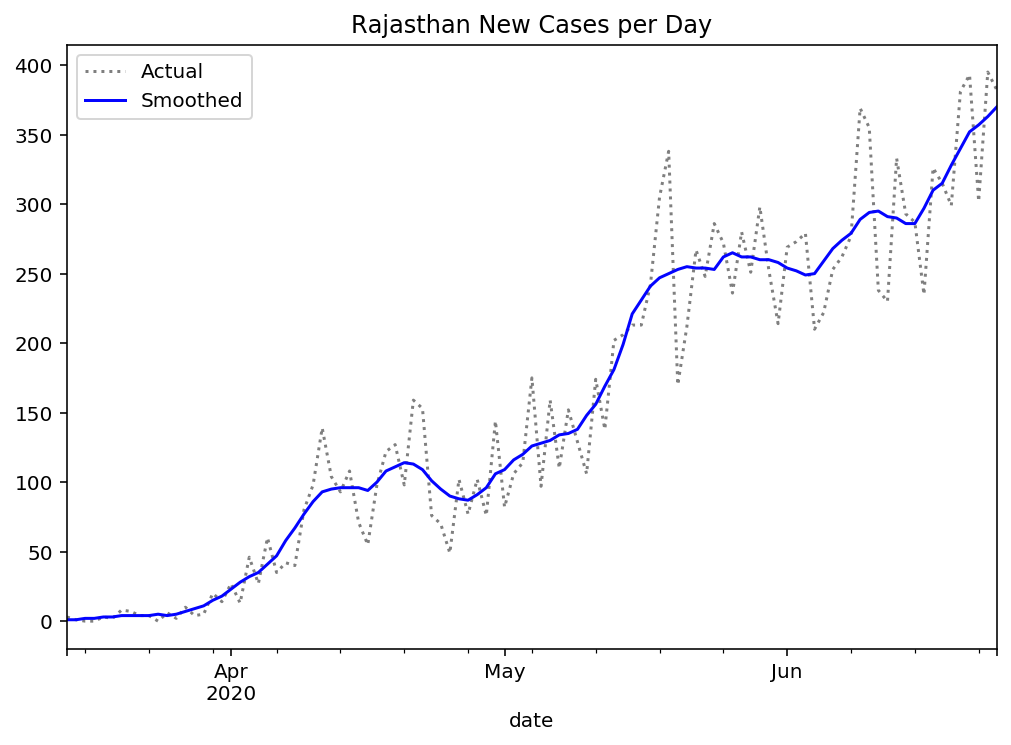

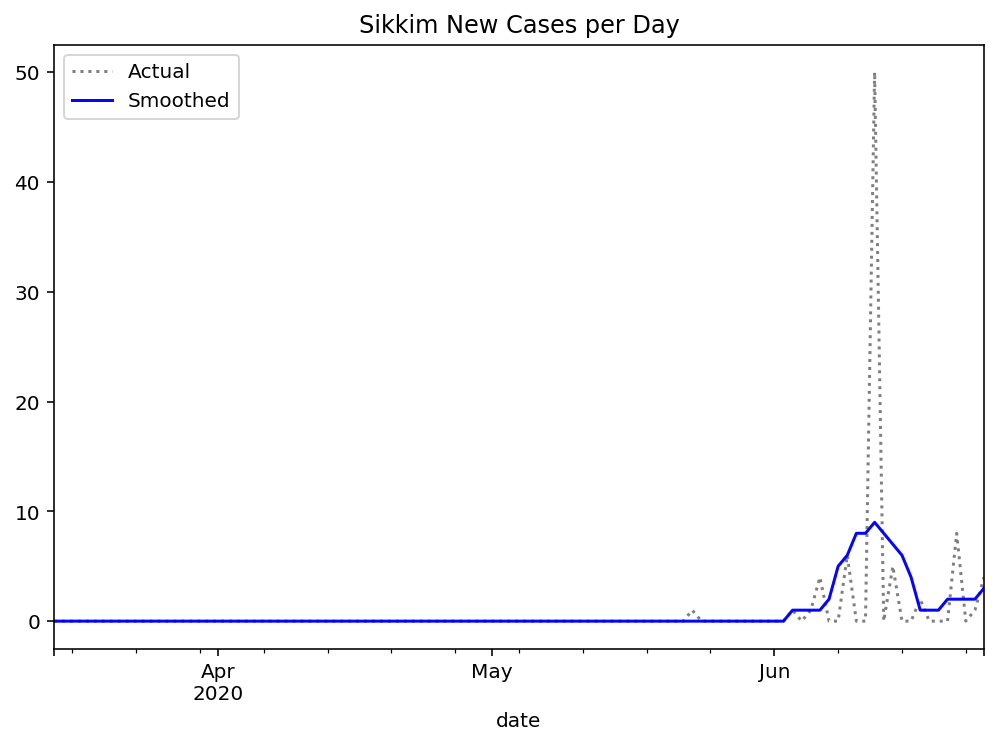

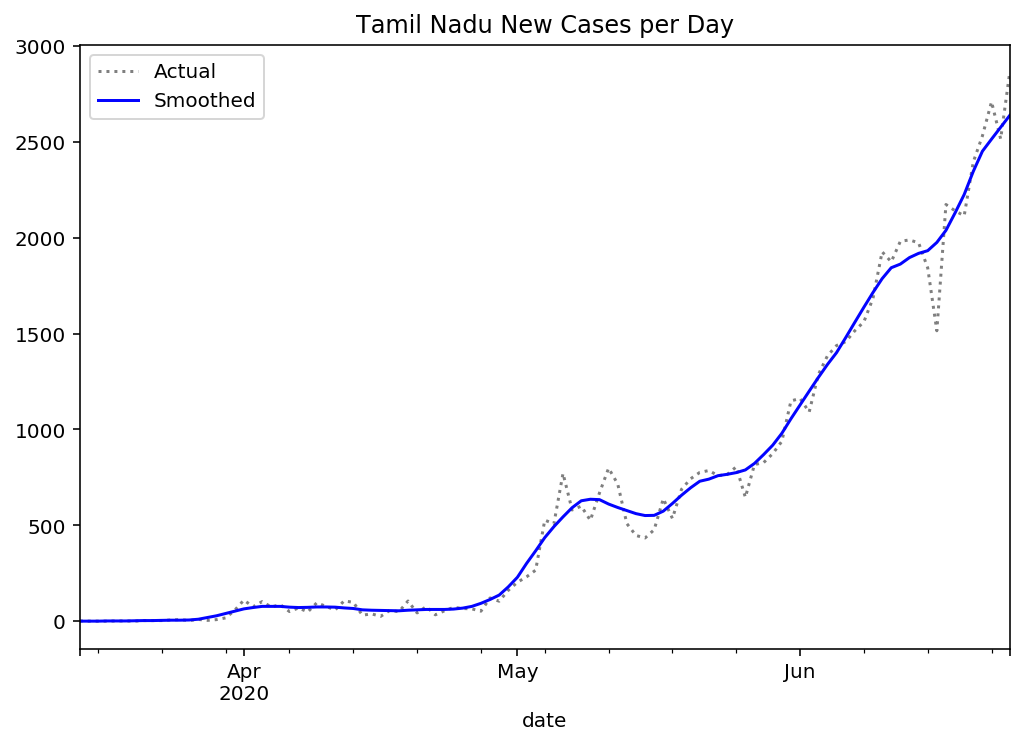

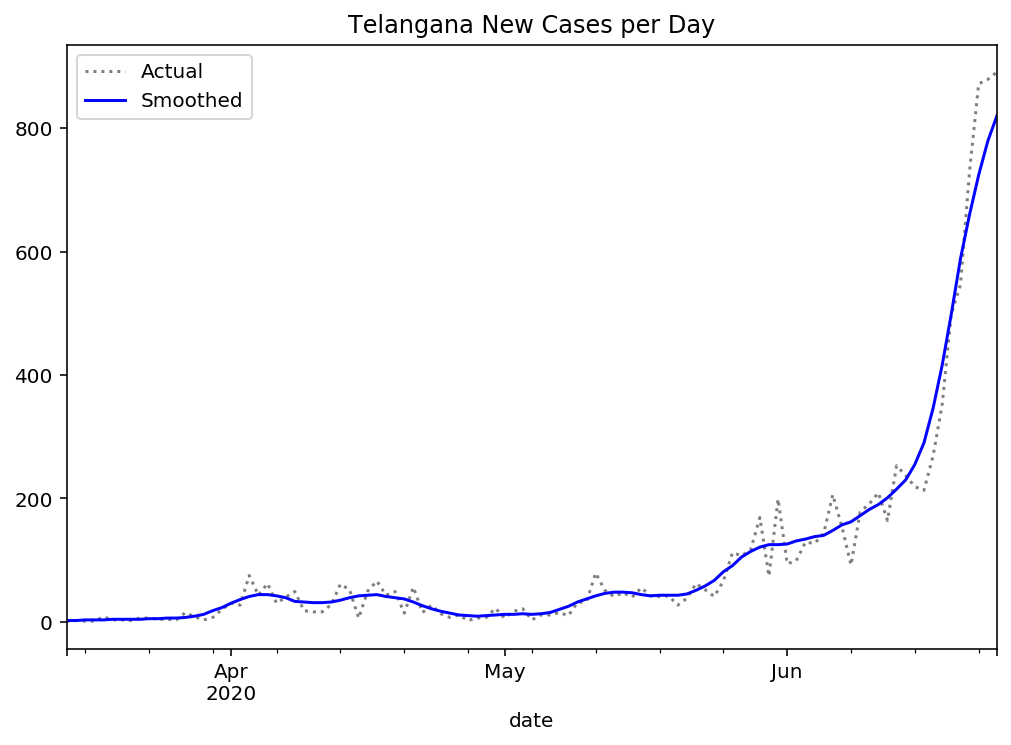

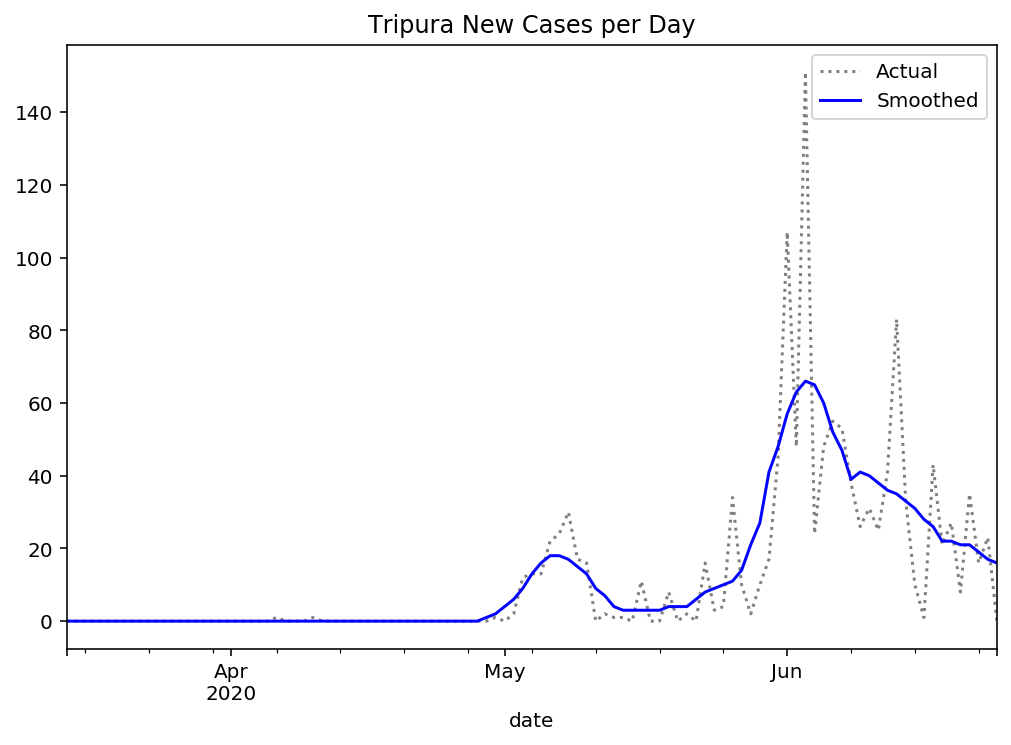

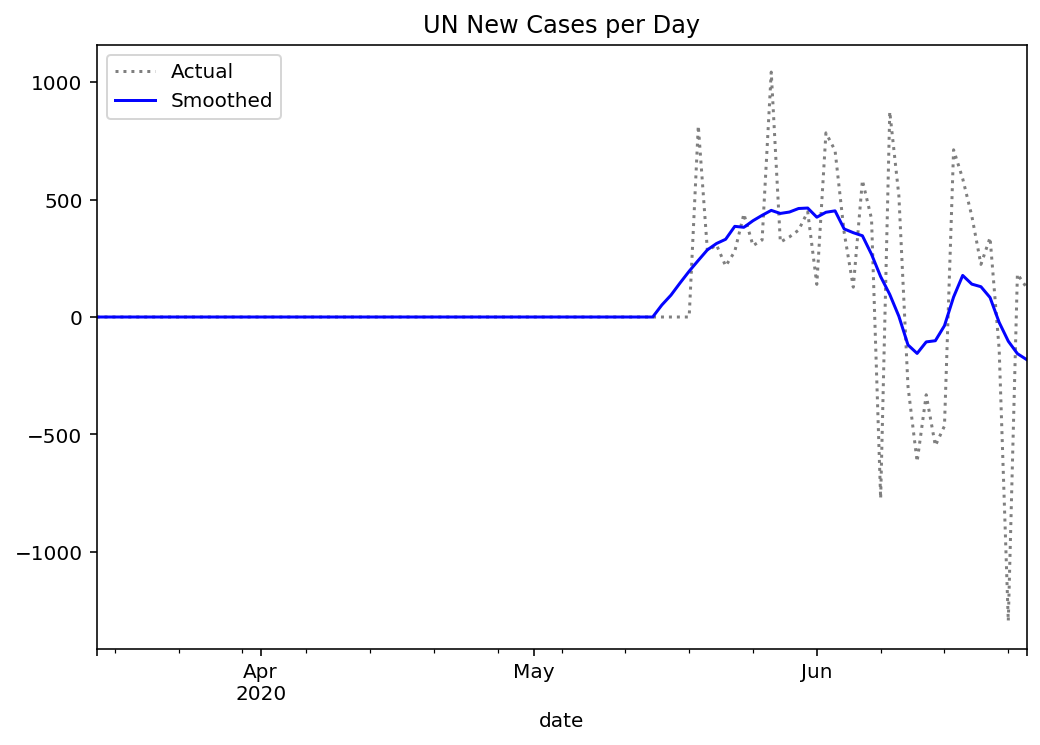

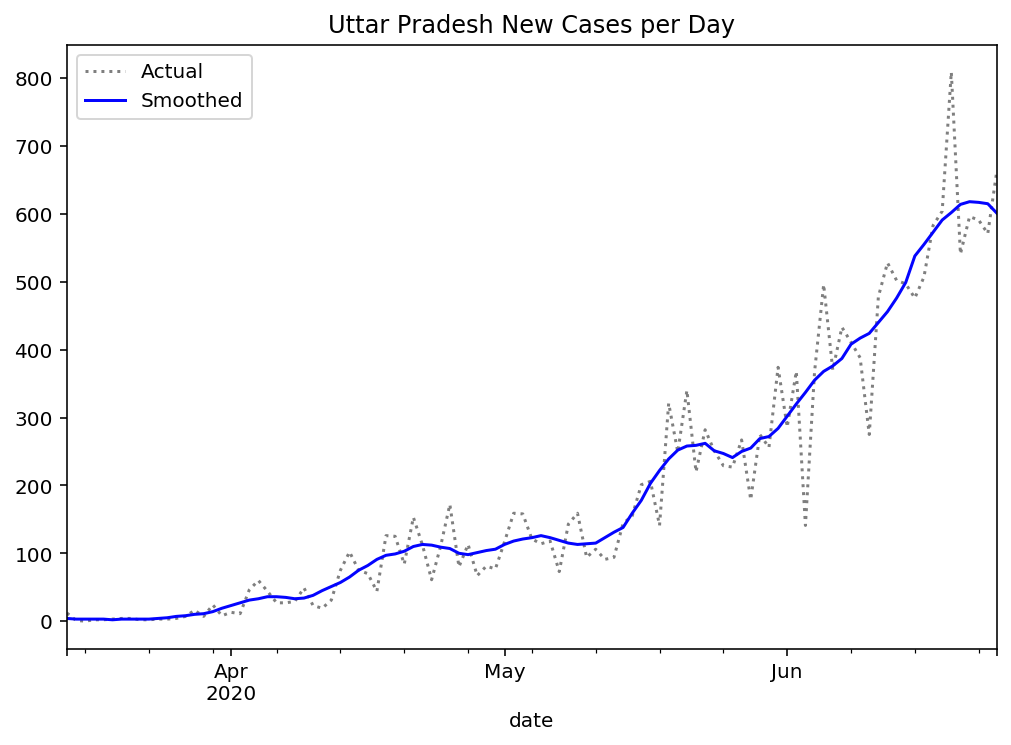

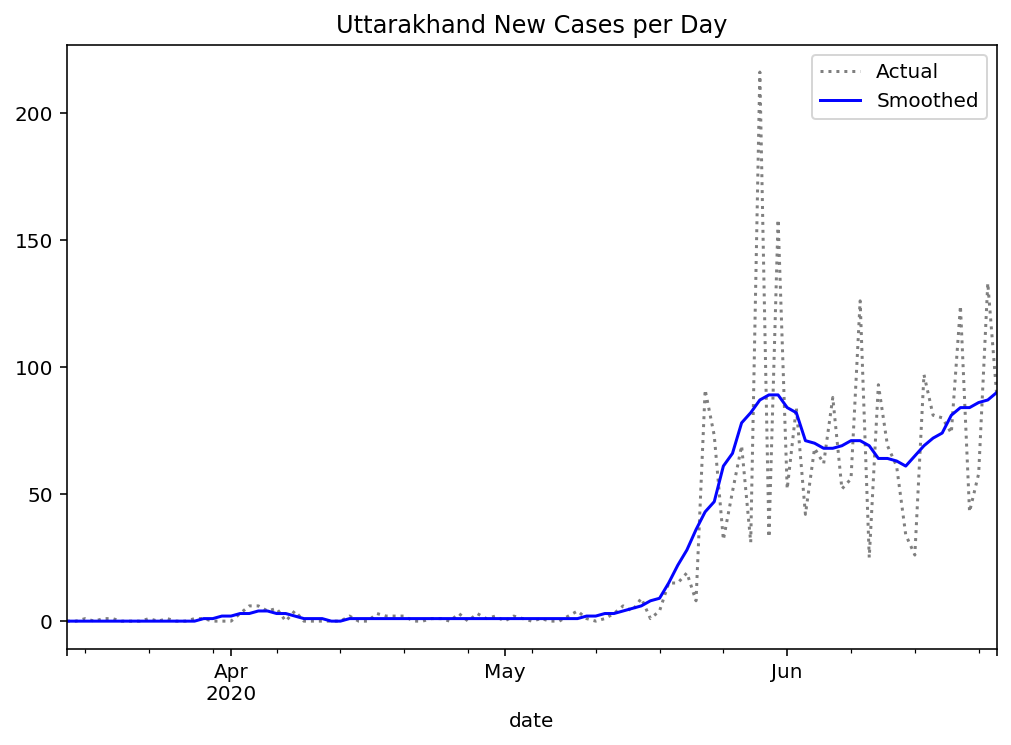

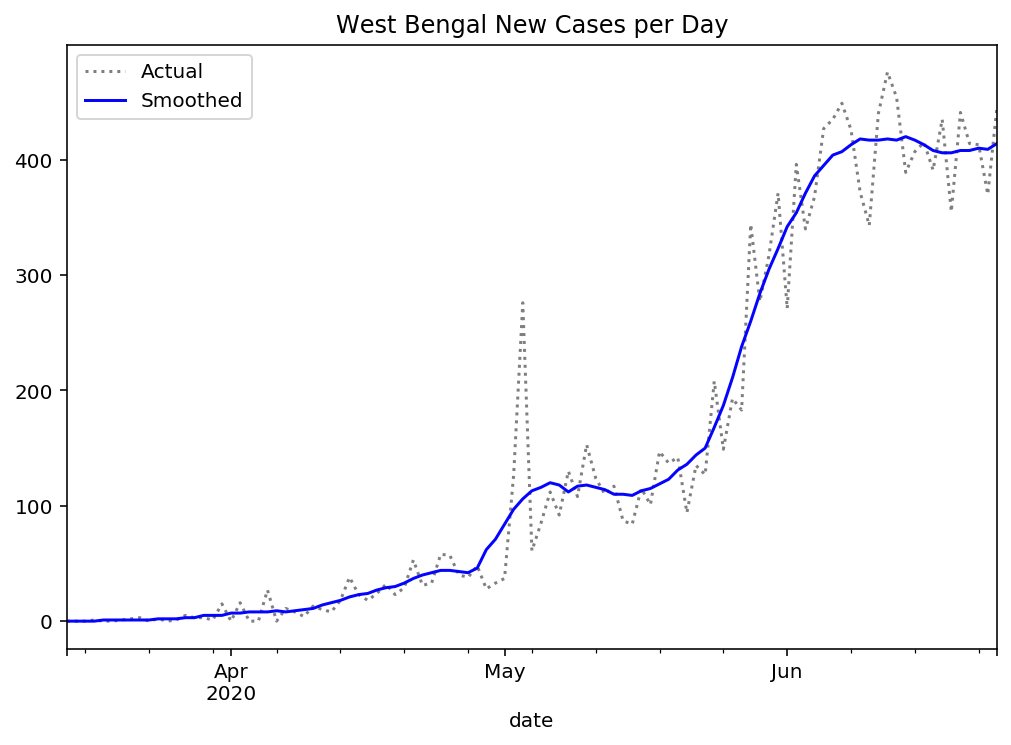

In [18]:
## Print all States graphs for New Cases Per Day
def prepare_cases(cases):

    smoothed = cases.rolling(9,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round()
    
    idx_start = np.searchsorted(smoothed, 0)
    
    smoothed = smoothed.iloc[idx_start:]
    original = cases.loc[smoothed.index]
    
    return original, smoothed

for state_name in states.index.get_level_values(0).drop_duplicates():
    cases = states.xs(state_name).rename(f"{state_name} cases")

    original, smoothed = prepare_cases(cases)

    fig, ax = plt.subplots(figsize=(600/72,400/72))
    
    original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True)

    ax = smoothed.plot(label='Smoothed', color ='blue', alpha=5, legend=True)
    ax.get_figure().set_facecolor('w')
    
#     plt.savefig(f'{state_name} New Cases per Day.png')


In [19]:
## Print all States graphs for New Cases Per Day
def prepare_cases(cases):

    smoothed = cases.rolling(9,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round()
    
    idx_start = np.searchsorted(smoothed, 0)
    
    smoothed = smoothed.iloc[idx_start:]
    original = cases.loc[smoothed.index]
    
    return original, smoothed

In [20]:

targets = ~states.index.get_level_values('state').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]
# states_to_process = states_to_process.loc[states_to_process[(states_to_process != 0)].first_valid_index():]

results = {}
skip_state_name = {}

for state_name, cases in states_to_process.groupby(level='state'):
    
    print(state_name)
    new, smoothed = prepare_cases(cases)

    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['new'] = new
    
    # Holds the log likelihood across all k for each value of sigma
    result['smoothed'] = smoothed

    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

Done.


In [21]:
final_results = {}
for state_name, result in results.items():
#     print(result['new'])
    result = pd.concat([result['new'], result['smoothed']], axis=1)
    final_results[state_name] = result
    clear_output(wait=True)
print('Done.') 

Done.


In [22]:
a = []
i=1
for state_name in states.index.get_level_values(0).drop_duplicates():
    
    a.append(final_results[state_name])
    

In [23]:
k = None
k = a[0]
i = 0
while i < len(a):
    k = k.append(a[i])
    i=i+1


In [24]:
k

positive  positive
state                       date                          
Andaman and Nicobar Islands 2020-03-14         0       0.0
                            2020-03-15         0       0.0
                            2020-03-16         0       0.0
                            2020-03-17         0       0.0
                            2020-03-18         0       0.0
...                                          ...       ...
West Bengal                 2020-06-20       441     408.0
                            2020-06-21       414     408.0
                            2020-06-22       413     410.0
                            2020-06-23       370     409.0
                            2020-06-24       445     414.0

[4120 rows x 2 columns]

In [25]:
cols = []
count = 1
for column in k.columns:
    if column == 'positive':
        cols.append(f'positive_{count}')
        count+=1
        continue
    cols.append(column)
k.columns = cols
k.rename(columns = {'positive_1':'new_cases', 'positive_2':'smoothed_9d'}, inplace = True)

In [26]:
k

new_cases  smoothed_9d
state                       date                              
Andaman and Nicobar Islands 2020-03-14          0          0.0
                            2020-03-15          0          0.0
                            2020-03-16          0          0.0
                            2020-03-17          0          0.0
                            2020-03-18          0          0.0
...                                           ...          ...
West Bengal                 2020-06-20        441        408.0
                            2020-06-21        414        408.0
                            2020-06-22        413        410.0
                            2020-06-23        370        409.0
                            2020-06-24        445        414.0

[4120 rows x 2 columns]

In [27]:
k.to_csv('new_cases_0625.csv')

In [28]:
# k.loc[(k.index.get_level_values('state') == 'Punjab')].tail(20)

In [29]:
# states1[states1.state=='Punjab'].tail(20)